In [33]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from math import isclose

from copy import deepcopy

import importlib

import time
import pickle
import random

In [34]:
import optimizor

#from optimizor import eta_2_Gamma
#from optimizor import Gamma_2_eta
#from optimizor import logdotexp

from optimizor import delta_2_eta0
from optimizor import Gamma_2_eta
from optimizor import eta0_2_delta
from optimizor import eta_2_Gamma
from optimizor import logdotexp

np.random.seed(0)
random.seed(0)

# Initialize Parameters

In [35]:
# parameters for data
experiment = 1


if experiment == 1:
    
    features = [{},
            {'Y'      : {'f'           : 'normal',
                         'lower_bound' : None,
                         'upper_bound' : None},
             'Y_star' : {'f'           : 'normal',
                         'lower_bound' : None,
                         'upper_bound' : None}}]
    
    K = [2,2]
    T = 1000
    
    jump_every = 1
    
    Gamma = [np.array([[0.99,0.01],
                       [0.01,0.99]]),
             [np.array([[0.75,0.25],
                        [0.25,0.75]]),
              np.array([[0.25,0.75],
                        [0.75,0.25]])]]

    delta = [np.array([0.5,0.5]),
             [np.array([0.5,0.5]),
              np.array([0.5,0.5])]]
    
    
    Gamma_coarse_full = np.kron(Gamma[0],np.ones((2,2)))
    Gamma_fine_full = np.block([[Gamma[1][0],np.tile(delta[1][1],(2,1))],
                                [np.tile(delta[1][0],(2,1)),Gamma[1][1]]])
    
    Gamma_full = Gamma_coarse_full * Gamma_fine_full
    delta_full = np.repeat(delta[0],2) * np.concatenate(delta[1])
    
    mus = {'Y'      : np.array([1.0,1.0,2.0,2.0]),
           'Y_star' : np.array([1.0,2.0,1.0,2.0])}
    
    sigs = {'Y'      : np.exp(np.array([-1.0,-1.0,-1.0,-1.0])), # coarse-scale sigs
            'Y_star' : np.exp(np.array([-1.0,-1.0,-1.0,-1.0]))} # fine-scale sigs
    
elif experiment == 2:
    
    features = [{},
                {'Y'      : {'f'           : 'normal',
                             'lower_bound' : None,
                             'upper_bound' : None}}]
    
    K = [1,3]
    T = 1000
    
    jump_every = 1
    
    Gamma = [np.array([[1.0]]),
             [np.array([[0.99,0.005,0.005],
                        [0.005,0.99,0.005],
                        [0.005,0.005,0.99]])]]

    delta = [np.array([1.0]),
             [np.array([0.3,0.3,0.4])]]
    
    Gamma_full = Gamma[1][0]
    delta_full = delta[1][0]
    
    mus =  {'Y' : np.array([1.0,2.0,3.0])}
    sigs = {'Y' : np.exp(np.array([-1.0,-1.0,-1.0]))}

    
# optimization parameters 
methods = ["SAGA","BFGS"]#,"EM"]#,"BFGS","CG"]
# methods = ["EM","SGD","SAG","SVRG","SAGA","GD","BFGS","Nelder-Mead"]

# pick optimization settings
step_sizes = {"EM"  : [None,None],
              "CG"  : [None,None],
              "BFGS": [None,None],
              "GD"  : [0.01,0.01],
              "SGD" : [0.01,0.01],
              "SAG" : [0.01,0.01],
              "SVRG": [0.01,0.01],
              "SAGA": [0.01,0.01]}

num_epochs = 100
tol = 1e-8
grad_tol = 0.0#1e-16

# Simulate Data

In [36]:
X = np.zeros(T,dtype=int)
data = []

for t in range(T):
    
    if t == 0:
        X[t] = np.random.choice(K[0]*K[1],p=delta_full)
    else:
        X[t] = np.random.choice(K[0]*K[1],p=Gamma_full[X[t-1]])

    data.append({'Y'      : mus['Y'][X[t]] + sigs['Y'][X[t]]*np.random.normal(),
                 'Y_star' : mus['Y_star'][X[t]] + sigs['Y_star'][X[t]]*np.random.normal()})

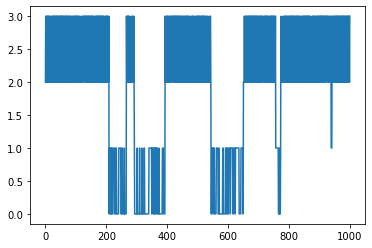

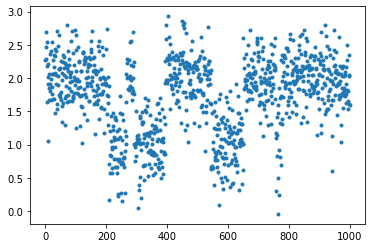

In [37]:
plt.plot(X)
plt.show()
plt.plot([x["Y"] for x in data],'.')
#plt.plot([x["Y_star"] for x in data],'.')
plt.show()

# save data
np.savetxt('../dat/data.csv', 
           np.array([x['Y'] for x in data]), 
           delimiter=',')

# Train the HMM

In [38]:
# initialize optims
optims = {}
times = {}

In [39]:
init_optim = optimizor.optimizor(data,features,K)
theta = deepcopy(init_optim.theta)
eta0 = deepcopy(init_optim.eta0)
eta = deepcopy(init_optim.eta)
del init_optim

for method in methods:
    
    for partial_E in [0,0.5,1]:
        
        if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead","CG"]:
            continue
        
        print(method,partial_E)
        print("")

        optims[(method,partial_E)] = optimizor.optimizor(data,features,K)
        optims[(method,partial_E)].step_size = step_sizes[method]
        optims[(method,partial_E)].param_bounds[1]["Y"]["mu"] = [-100,100]
        optims[(method,partial_E)].param_bounds[1]["Y"]["log_sig"] = [-5,5]
        optims[(method,partial_E)].jump_every = jump_every
        optims[(method,partial_E)].param_bounds[1]["Y_star"]["mu"] = [-100,100]
        optims[(method,partial_E)].param_bounds[1]["Y_star"]["log_sig"] = [-5,5]
        
        # set parameters
        optims[(method,partial_E)].theta = deepcopy(theta)
        optims[(method,partial_E)].eta0 = deepcopy(eta0)
        optims[(method,partial_E)].eta = deepcopy(eta)
        '''
        if experiment == 1:
            optims[(method,partial_E)].theta = [{},
                                                [{'Y'      : {'mu': np.array([0.75,1.25]),
                                                             'log_sig': np.array([0.0,0.0])},
                                                  'Y_star' : {'mu': np.array([0.5,1.75]),
                                                             'log_sig': np.array([0.0,0.0])}},
                                                 {'Y'      : {'mu': np.array([1.8,2.3]),
                                                             'log_sig': np.array([0.0,0.0])},
                                                  'Y_star' : {'mu': np.array([1.5,3.0]),
                                                             'log_sig': np.array([0.0,0.0])}}]]

            optims[(method,partial_E)].Gamma = [np.array([[0.9,0.1],
                                                          [0.1,0.9]]),
                                                [np.array([[0.75,0.25],
                                                           [0.25,0.75]]),
                                                 np.array([[0.25,0.75],
                                                           [0.75,0.25]])]]

            optims[(method,partial_E)].delta = [np.array([0.9,0.1]),
                                                 [np.array([0.9,0.1]),
                                                  np.array([0.1,0.9])]]
            optims[(method,partial_E)].eta0 = delta_2_eta0(optims[(method,partial_E)].delta)
            optims[(method,partial_E)].eta = Gamma_2_eta(optims[(method,partial_E)].Gamma)
            
        if experiment == 2:
            
            optims[(method,partial_E)].theta = [{},
                                                [{'Y': {'mu': np.array([0.5,2.5,3.6]),
                                                        'log_sig': np.array([-1.5,0.5,0.0])}}]]

            optims[(method,partial_E)].Gamma = [np.array([[1.0]]),
                                                 [np.array([[0.99,0.005,0.005],
                                                            [0.005,0.99,0.005],
                                                            [0.005,0.005,0.99]])]]

            optims[(method,partial_E)].delta = [np.array([1.0]),
                                                 [np.array([0.3,0.3,0.4])]]

            optims[(method,partial_E)].eta0 = delta_2_eta0(optims[(method,partial_E)].delta)
            optims[(method,partial_E)].eta = Gamma_2_eta(optims[(method,partial_E)].Gamma)
        '''    
        
        if not (step_sizes[method][0] is None):
            optims[(method,partial_E)].L_theta = 1.0 / step_sizes[method][0]
            optims[(method,partial_E)].L_eta = 1.0 / step_sizes[method][1]
        
        if partial_E == 0:
            optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                  method=method,
                                                  max_iters=T,
                                                  partial_E=False,
                                                  alpha_theta=step_sizes[method][0],
                                                  alpha_eta=step_sizes[method][1],
                                                  tol=tol,
                                                  grad_tol=grad_tol,
                                                  record_like=True)
        elif partial_E == 0.5:
            if method in ["SGD","SAG","SVRG","SAGA"]:
                optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                      method=method,
                                                      max_iters=T,
                                                      partial_E=True,
                                                      alpha_theta=step_sizes[method][0],
                                                      alpha_eta=step_sizes[method][1],
                                                      tol=tol,
                                                      grad_tol=grad_tol,
                                                      record_like=True)
        elif partial_E == 1:
            if method in ["SGD","SAG","SVRG","SAGA"]:
                optims[(method,partial_E)].train_HHMM(num_epochs=num_epochs,
                                                      method=method,
                                                      max_iters=10*T,
                                                      partial_E=True,
                                                      alpha_theta=step_sizes[method][0],
                                                      alpha_eta=step_sizes[method][1],
                                                      tol=tol,
                                                      grad_tol=grad_tol,
                                                      record_like=True)

SAGA 0

starting epoch 0.0

current parameters:
[{}, [{'Y': {'mu': array([2.08321603, 1.90319169]), 'log_sig': array([-1.30439504,  0.45288869])}, 'Y_star': {'mu': array([1.25113727, 0.84378117]), 'log_sig': array([ 0.31597872, -1.17711692])}}, {'Y': {'mu': array([0.85055446, 2.25453916]), 'log_sig': array([0.52168412, 1.01295849])}, 'Y_star': {'mu': array([1.4907918 , 1.26665794]), 'log_sig': array([-1.37997361, -0.15690217])}}]]
[array([[ 0.        , -0.40779432],
       [-1.96693109,  0.        ]]), [array([[ 0.        , -0.56836615],
       [-0.4230654 ,  0.        ]]), array([[ 0.        , -2.00514443],
       [-0.89334771,  0.        ]])]]
[array([0.78374449, 1.90134005]), [array([-0.52493942,  0.274417  ]), array([-1.09997081, -0.40435222])]]

current gradients:
[{}, [{'Y': {'mu': array([0., 0.]), 'log_sig': array([0., 0.])}, 'Y_star': {'mu': array([0., 0.]), 'log_sig': array([0., 0.])}}, {'Y': {'mu': array([0., 0.]), 'log_sig': array([0., 0.])}, 'Y_star': {'mu': array([0., 0.])

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/optimizor.py:1939: RuntimeWarning:

invalid value encountered in double_scalars



M-step failed to converge: maximum number of iterations reached
...done

L_theta:  49.99999999999919
L_eta:  100.06933874625645

starting epoch 1.0

current parameters:
[{}, [{'Y': {'mu': array([2.02691624, 1.665857  ]), 'log_sig': array([-1.26879047,  0.04700903])}, 'Y_star': {'mu': array([1.48500311, 0.88298235]), 'log_sig': array([-0.40770193, -1.22962425])}}, {'Y': {'mu': array([1.08882041, 2.13774243]), 'log_sig': array([0.01353109, 0.5655125 ])}, 'Y_star': {'mu': array([1.61231615, 1.59650027]), 'log_sig': array([-1.18728307, -0.25104206])}}]]
[array([[ 0.        , -0.73118287],
       [-1.66822328,  0.        ]]), [array([[ 0.        , -0.96149116],
       [-0.4756493 ,  0.        ]]), array([[ 0.        , -1.97931359],
       [-0.91068704,  0.        ]])]]
[array([0.78374449, 1.90064076]), [array([-0.52493942,  0.15325628]), array([-1.09997081, -0.53088262])]]

current gradients:
[{}, [{'Y': {'mu': array([-148.34292825,  -45.45325213]), 'log_sig': array([ 23.92036435, -89.31902

...done
-1503.3319233147874
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.069410897524406
L_eta:  12.526020063494142

starting epoch 6.0

current parameters:
[{}, [{'Y': {'mu': array([2.05319614, 1.53157567]), 'log_sig': array([-1.25576104, -0.55201445])}, 'Y_star': {'mu': array([1.52048801, 0.83644993]), 'log_sig': array([-0.49650376, -1.36531553])}}, {'Y': {'mu': array([1.0024302 , 1.87984099]), 'log_sig': array([-1.01379634, -0.7312946 ])}, 'Y_star': {'mu': array([1.60290147, 1.53413348]), 'log_sig': array([-0.49482633, -0.53370923])}}]]
[array([[ 0.        , -2.26187589],
       [-1.60840947,  0.        ]]), [array([[ 0.        , -2.08266011],
       [-0.02562398,  0.        ]]), array([[ 0.        , -2.37435746],
       [-1.0505622 ,  0.        ]])]]
[array([0.78374449, 1.89091957]), [array([-0.52493942,  0.02419831]), array([-1.09997081, -0.46165363])]]

current gradients:
[{}, [{'Y': {'mu': array([-2.13945987,  4.2401212

...done
-1353.214512517455
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.156445587440093
L_eta:  0.3914381269841623

starting epoch 11.0

current parameters:
[{}, [{'Y': {'mu': array([2.02241473, 1.85353708]), 'log_sig': array([-1.13194239, -0.89161938])}, 'Y_star': {'mu': array([1.5081355 , 0.82140762]), 'log_sig': array([-0.48996608, -1.45481244])}}, {'Y': {'mu': array([1.00482687, 1.99363435]), 'log_sig': array([-0.97646496, -0.89428893])}, 'Y_star': {'mu': array([1.47494586, 1.50865783]), 'log_sig': array([-0.4642546 , -0.59100147])}}]]
[array([[ 0.        , -4.56041464],
       [-3.6955699 ,  0.        ]]), [array([[ 0.        , -2.54502779],
       [ 2.72809936,  0.        ]]), array([[ 0.        , -5.35617308],
       [-1.94859773,  0.        ]])]]
[array([0.78374449, 1.84892262]), [array([-0.52493942, -0.99425444]), array([-1.09997081,  0.08511375])]]

current gradients:
[{}, [{'Y': {'mu': array([-7.66674283,  4.2887664

...done
-1329.831441202077
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.243782439910582
L_eta:  0.1962624649264696

starting epoch 16.0

current parameters:
[{}, [{'Y': {'mu': array([2.01149147, 1.98649815]), 'log_sig': array([-1.11490414, -0.98630051])}, 'Y_star': {'mu': array([1.57623536, 0.77166216]), 'log_sig': array([-0.52755062, -1.56932233])}}, {'Y': {'mu': array([1.00506397, 2.04973017]), 'log_sig': array([-0.97679408, -0.99837511])}, 'Y_star': {'mu': array([1.47290412, 1.47621906]), 'log_sig': array([-0.46410031, -0.58674222])}}]]
[array([[ 0.        , -4.78997398],
       [-3.85452594,  0.        ]]), [array([[ 0.        , -1.56005901],
       [ 5.36124094,  0.        ]]), array([[ 0.        , -7.38147498],
       [-1.65701212,  0.        ]])]]
[array([0.78374449, 1.99668687]), [array([-0.52493942, -2.93111321]), array([-1.09997081,  0.02173331])]]

current gradients:
[{}, [{'Y': {'mu': array([-4.28829314,  3.7857049

...done
-1304.8657622877129
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.33142250396856
L_eta:  0.39416079447044516

starting epoch 21.0

current parameters:
[{}, [{'Y': {'mu': array([2.00643989, 2.01274763]), 'log_sig': array([-1.11125812, -1.04228787])}, 'Y_star': {'mu': array([1.68447145, 0.77787994]), 'log_sig': array([-0.62866352, -1.39344806])}}, {'Y': {'mu': array([1.00541562, 2.087013  ]), 'log_sig': array([-0.97721817, -1.07546074])}, 'Y_star': {'mu': array([1.47266424, 1.48671623]), 'log_sig': array([-0.46390738, -0.630294  ])}}]]
[array([[ 0.        , -4.82563958],
       [-3.85640377,  0.        ]]), [array([[ 0.        , -0.68684796],
       [ 6.27958365,  0.        ]]), array([[ 0.        , -7.94481818],
       [-1.24901883,  0.        ]])]]
[array([0.78374449, 2.11814827]), [array([-0.52493942, -3.75330938]), array([-1.09997081,  0.25822392])]]

current gradients:
[{}, [{'Y': {'mu': array([-1.59186475,  0.847094

...done
-1277.722683155974
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.41936683228815
L_eta:  0.3955292216211189

starting epoch 26.0

current parameters:
[{}, [{'Y': {'mu': array([2.0046278, 2.0143098]), 'log_sig': array([-1.11933501, -1.04204232])}, 'Y_star': {'mu': array([1.77895611, 0.84005106]), 'log_sig': array([-0.729431  , -1.18553217])}}, {'Y': {'mu': array([1.00566311, 2.09178689]), 'log_sig': array([-0.97701081, -1.13479233])}, 'Y_star': {'mu': array([1.47236699, 1.48857776]), 'log_sig': array([-0.46384995, -0.64126103])}}]]
[array([[ 0.        , -4.83891497],
       [-3.86620007,  0.        ]]), [array([[0.        , 0.11649944],
       [6.41207032, 0.        ]]), array([[ 0.        , -8.29396296],
       [-1.15232648,  0.        ]])]]
[array([0.78374449, 2.24142663]), [array([-0.52493942, -4.12416707]), array([-1.09997081,  0.46765837])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.57550075, -0.43106951]), 'l

...done
-1269.839858313167
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.507616481198742
L_eta:  0.39690239960671714

starting epoch 31.0

current parameters:
[{}, [{'Y': {'mu': array([2.00522006, 2.01290536]), 'log_sig': array([-1.12403762, -1.03564792])}, 'Y_star': {'mu': array([1.80974398, 0.88571202]), 'log_sig': array([-0.74649369, -1.09509543])}}, {'Y': {'mu': array([1.00559822, 2.06663223]), 'log_sig': array([-0.97680167, -1.18103313])}, 'Y_star': {'mu': array([1.47203287, 1.47324856]), 'log_sig': array([-0.46379559, -0.59831153])}}]]
[array([[ 0.        , -4.82347551],
       [-3.87660213,  0.        ]]), [array([[0.        , 0.47881759],
       [5.69772414, 0.        ]]), array([[ 0.        , -8.54605592],
       [-1.29496098,  0.        ]])]]
[array([0.78374449, 2.11329115]), [array([-0.52493942, -4.17788306]), array([-1.09997081,  0.88736715])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.03886288, -0.11477278])

...done
-1267.4346379531908
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.596172510696178
L_eta:  0.39828034492093656

starting epoch 36.0

current parameters:
[{}, [{'Y': {'mu': array([2.00563273, 2.01241394]), 'log_sig': array([-1.12345311, -1.03511492])}, 'Y_star': {'mu': array([1.82505478, 0.89852394]), 'log_sig': array([-0.76426175, -1.07534285])}}, {'Y': {'mu': array([1.00540831, 2.04851034]), 'log_sig': array([-0.97683205, -1.20397936])}, 'Y_star': {'mu': array([1.47182725, 1.451545  ]), 'log_sig': array([-0.46379508, -0.55578712])}}]]
[array([[ 0.        , -4.79478171],
       [-3.87212229,  0.        ]]), [array([[0.        , 0.58645224],
       [4.10812672, 0.        ]]), array([[ 0.        , -8.74854587],
       [-1.4644558 ,  0.        ]])]]
[array([0.78374449, 1.92086525]), [array([-0.52493942, -4.1268737 ]), array([-1.09997081,  1.39064327])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.22447969, -0.19911972]

...done
-1262.6026978895313
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.685035984457087
L_eta:  0.39966307411474783

starting epoch 41.0

current parameters:
[{}, [{'Y': {'mu': array([2.00664802, 2.01051498]), 'log_sig': array([-1.12103981, -1.04075191])}, 'Y_star': {'mu': array([1.85575179, 0.90432056]), 'log_sig': array([-0.81898453, -1.07320171])}}, {'Y': {'mu': array([1.00532587, 2.0462029 ]), 'log_sig': array([-0.97692911, -1.20999671])}, 'Y_star': {'mu': array([1.47178179, 1.44141209]), 'log_sig': array([-0.46377448, -0.54408485])}}]]
[array([[ 0.        , -4.77940608],
       [-3.85804444,  0.        ]]), [array([[0.        , 0.7197675 ],
       [2.71280092, 0.        ]]), array([[ 0.        , -8.92052639],
       [-1.50538569,  0.        ]])]]
[array([0.78374449, 1.92658676]), [array([-0.52493942, -4.19253068]), array([-1.09997081,  1.70150392])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.3285247, -0.2773305]),

...done
-1256.3480583051496
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.774207969850575
L_eta:  0.4010506037965767

starting epoch 46.0

current parameters:
[{}, [{'Y': {'mu': array([2.00747339, 2.00896796]), 'log_sig': array([-1.11940514, -1.04831272])}, 'Y_star': {'mu': array([1.89913323, 0.91611845]), 'log_sig': array([-0.90581395, -1.06492151])}}, {'Y': {'mu': array([1.00529645, 2.05288995]), 'log_sig': array([-0.97702726, -1.22116879])}, 'Y_star': {'mu': array([1.47171757, 1.45622722]), 'log_sig': array([-0.46375633, -0.56262704])}}]]
[array([[ 0.        , -4.80162826],
       [-3.85338912,  0.        ]]), [array([[0.        , 0.88538555],
       [1.89958693, 0.        ]]), array([[ 0.        , -9.07117662],
       [-1.34104802,  0.        ]])]]
[array([0.78374449, 2.11181961]), [array([-0.52493942, -4.4133815 ]), array([-1.09997081,  1.80407052])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.15494085, -0.30985464])

...done
-1252.5654725365584
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.86368953795149
L_eta:  0.40244295063251107

starting epoch 51.0

current parameters:
[{}, [{'Y': {'mu': array([2.00746733, 2.00904493]), 'log_sig': array([-1.12034523, -1.05152438])}, 'Y_star': {'mu': array([1.93295687, 0.93564372]), 'log_sig': array([-0.96693702, -1.04242549])}}, {'Y': {'mu': array([1.00537294, 2.05999146]), 'log_sig': array([-0.97697852, -1.23804449])}, 'Y_star': {'mu': array([1.47165315, 1.47942574]), 'log_sig': array([-0.46368563, -0.59560045])}}]]
[array([[ 0.        , -4.8240296 ],
       [-3.85029024,  0.        ]]), [array([[0.        , 1.10438272],
       [1.53304877, 0.        ]]), array([[ 0.        , -9.20892077],
       [-1.16323949,  0.        ]])]]
[array([0.78374449, 2.38116519]), [array([-0.52493942, -4.62562791]), array([-1.09997081,  1.79443611])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.0868139 ,  0.00911465])

...done
-1251.5044997300306
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.953481763553032
L_eta:  0.403840131346497

starting epoch 56.0

current parameters:
[{}, [{'Y': {'mu': array([2.00722301, 2.00925459]), 'log_sig': array([-1.12103229, -1.05280336])}, 'Y_star': {'mu': array([1.94951848, 0.94795528]), 'log_sig': array([-0.99683894, -1.02782948])}}, {'Y': {'mu': array([1.00540871, 2.06293966]), 'log_sig': array([-0.97693555, -1.25029517])}, 'Y_star': {'mu': array([1.47160288, 1.48807992]), 'log_sig': array([-0.46366011, -0.61674261])}}]]
[array([[ 0.        , -4.83030637],
       [-3.84596782,  0.        ]]), [array([[0.        , 1.22581456],
       [1.36790839, 0.        ]]), array([[ 0.        , -9.33278689],
       [-1.0989338 ,  0.        ]])]]
[array([0.78374449, 2.6357133 ]), [array([-0.52493942, -4.77474159]), array([-1.09997081,  1.74975419])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.09891391,  0.01933553]),

...done
-1251.3168616438568
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.0435857251798
L_eta:  0.4052421627205414

starting epoch 61.0

current parameters:
[{}, [{'Y': {'mu': array([2.00704879, 2.00940954]), 'log_sig': array([-1.12138588, -1.05339861])}, 'Y_star': {'mu': array([1.95667013, 0.95414298]), 'log_sig': array([-1.00943227, -1.01906723])}}, {'Y': {'mu': array([1.00543859, 2.06475928]), 'log_sig': array([-0.97690532, -1.25525495])}, 'Y_star': {'mu': array([1.47159369, 1.48991173]), 'log_sig': array([-0.4636394 , -0.62488948])}}]]
[array([[ 0.        , -4.83227879],
       [-3.84278744,  0.        ]]), [array([[0.        , 1.28474823],
       [1.30102135, 0.        ]]), array([[ 0.        , -9.44538465],
       [-1.07618561,  0.        ]])]]
[array([0.78374449, 2.86605818]), [array([-0.52493942, -4.88476585]), array([-1.09997081,  1.68339561])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.03435231,  0.00378769]), 

...done
-1251.3337196735363
log likelihood decreased. Trying again...
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.13400250510129
L_eta:  0.4066490615949229

starting epoch 66.0

current parameters:
[{}, [{'Y': {'mu': array([2.00696304, 2.00942617]), 'log_sig': array([-1.12158588, -1.05361959])}, 'Y_star': {'mu': array([1.95958245, 0.95669645]), 'log_sig': array([-1.01413392, -1.0158681 ])}}, {'Y': {'mu': array([1.00545201, 2.06600378]), 'log_sig': array([-0.97689152, -1.25688921])}, 'Y_star': {'mu': array([1.47159619, 1.48993083]), 'log_sig': array([-0.46363086, -0.62857789])}}]]
[array([[ 0.        , -4.8328685 ],
       [-3.84117271,  0.        ]]), [array([[0.        , 1.31041707],
       [1.27607353, 0.        ]]), array([[ 0.        , -9.54642803],
       [-1.07234911,  0.        ]])]]
[array([0.78374449, 3.04171322]), [array([-0.52493942, -4.9702061 ]), array([-1.09997081,  1.60673554])]]

current gradients:
[{}, [{'Y':

...done
-1251.3894110134172
log likelihood decreased. Trying again...
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.224733189343763
L_eta:  0.4080608448683754

starting epoch 71.0

current parameters:
[{}, [{'Y': {'mu': array([2.00691728, 2.00942468]), 'log_sig': array([-1.12169938, -1.05373807])}, 'Y_star': {'mu': array([1.96079687, 0.95775084]), 'log_sig': array([-1.01611571, -1.01428257])}}, {'Y': {'mu': array([1.00546146, 2.06722595]), 'log_sig': array([-0.97688312, -1.25707687])}, 'Y_star': {'mu': array([1.47160244, 1.48942545]), 'log_sig': array([-0.46362665, -0.63062498])}}]]
[array([[ 0.        , -4.83315965],
       [-3.84018822,  0.        ]]), [array([[0.        , 1.32131884],
       [1.26567267, 0.        ]]), array([[ 0.        , -9.63779825],
       [-1.0743916 ,  0.        ]])]]
[array([0.78374449, 3.1839541 ]), [array([-0.52493942, -5.04408999]), array([-1.09997081,  1.52512349])]]

current gradients:
[{}, [{'Y'

...done
-1251.460194868127
log likelihood decreased. Trying again...
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.315778867703596
L_eta:  0.4094775294982965

starting epoch 76.0

current parameters:
[{}, [{'Y': {'mu': array([2.0068914 , 2.00940124]), 'log_sig': array([-1.12180651, -1.05381342])}, 'Y_star': {'mu': array([1.96131462, 0.95822424]), 'log_sig': array([-1.01695349, -1.0136484 ])}}, {'Y': {'mu': array([1.00546939, 2.06859246]), 'log_sig': array([-0.9768777 , -1.25676011])}, 'Y_star': {'mu': array([1.47161119, 1.48854887]), 'log_sig': array([-0.4636245 , -0.63181099])}}]]
[array([[ 0.        , -4.83335711],
       [-3.83966991,  0.        ]]), [array([[0.        , 1.32568535],
       [1.26145634, 0.        ]]), array([[ 0.        , -9.72287202],
       [-1.07994999,  0.        ]])]]
[array([0.78374449, 3.29424561]), [array([-0.52493942, -5.11132816]), array([-1.09997081,  1.43231183])]]

current gradients:
[{}, [{'Y':

...done
-1251.539387476227
log likelihood decreased. Trying again...
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.40714063376196
L_eta:  0.4108991325009762

starting epoch 81.0

current parameters:
[{}, [{'Y': {'mu': array([2.00686472, 2.00937165]), 'log_sig': array([-1.12189516, -1.05386653])}, 'Y_star': {'mu': array([1.96153754, 0.95841355]), 'log_sig': array([-1.01730262, -1.01338864])}}, {'Y': {'mu': array([1.00547461, 2.06978438]), 'log_sig': array([-0.97687531, -1.25630644])}, 'Y_star': {'mu': array([1.47162023, 1.48749115]), 'log_sig': array([-0.46362439, -0.63264666])}}]]
[array([[ 0.        , -4.8336411 ],
       [-3.83956091,  0.        ]]), [array([[0.        , 1.32729462],
       [1.25943299, 0.        ]]), array([[ 0.        , -9.80074255],
       [-1.0866532 ,  0.        ]])]]
[array([0.78374449, 3.36995027]), [array([-0.52493942, -5.17239907]), array([-1.09997081,  1.33656807])]]

current gradients:
[{}, [{'Y': 

...done
-1251.6185836983595
log likelihood decreased. Trying again...
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.49881958489531
L_eta:  0.4123256709517591

starting epoch 86.0

current parameters:
[{}, [{'Y': {'mu': array([2.00684781, 2.00933809]), 'log_sig': array([-1.12197296, -1.0539117 ])}, 'Y_star': {'mu': array([1.96164763, 0.95850197]), 'log_sig': array([-1.01745139, -1.01327644])}}, {'Y': {'mu': array([1.00547834, 2.07104597]), 'log_sig': array([-0.97687377, -1.25575174])}, 'Y_star': {'mu': array([1.47162968, 1.48620965]), 'log_sig': array([-0.46362486, -0.63347341])}}]]
[array([[ 0.        , -4.83393397],
       [-3.83975245,  0.        ]]), [array([[0.        , 1.32777206],
       [1.25858283, 0.        ]]), array([[ 0.        , -9.87204711],
       [-1.09425047,  0.        ]])]]
[array([0.78374449, 3.41685894]), [array([-0.52493942, -5.22872785]), array([-1.09997081,  1.23857443])]]

current gradients:
[{}, [{'Y':

...done
-1251.6978646526375
log likelihood decreased. Trying again...
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.59081682229058
L_eta:  0.41375716198528184

starting epoch 91.0

current parameters:
[{}, [{'Y': {'mu': array([2.00683814, 2.00930691]), 'log_sig': array([-1.12205635, -1.05395316])}, 'Y_star': {'mu': array([1.96171481, 0.95855264]), 'log_sig': array([-1.01755401, -1.01321367])}}, {'Y': {'mu': array([1.00547955, 2.07227744]), 'log_sig': array([-0.97687521, -1.25500606])}, 'Y_star': {'mu': array([1.47163901, 1.48490503]), 'log_sig': array([-0.46362483, -0.63424637])}}]]
[array([[ 0.        , -4.83435754],
       [-3.84020601,  0.        ]]), [array([[0.        , 1.32784685],
       [1.25808409, 0.        ]]), array([[ 0.        , -9.93964809],
       [-1.10276079,  0.        ]])]]
[array([0.78374449, 3.43769156]), [array([-0.52493942, -5.28204364]), array([-1.09997081,  1.14067332])]]

current gradients:
[{}, [{'Y'

...done
-1251.78023320097
log likelihood decreased. Trying again...
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.683133450957676
L_eta:  0.4151936227956668

starting epoch 96.0

current parameters:
[{}, [{'Y': {'mu': array([2.00682943, 2.00927225]), 'log_sig': array([-1.12212593, -1.05399611])}, 'Y_star': {'mu': array([1.96175729, 0.95859448]), 'log_sig': array([-1.01761747, -1.01317592])}}, {'Y': {'mu': array([1.00547945, 2.07343182]), 'log_sig': array([-0.97687738, -1.25458247])}, 'Y_star': {'mu': array([1.47164825, 1.48341519]), 'log_sig': array([-0.46362674, -0.63505372])}}]]
[array([[ 0.        , -4.83492949],
       [-3.84104127,  0.        ]]), [array([[0.        , 1.32765993],
       [1.25778554, 0.        ]]), array([[  0.        , -10.00219637],
       [ -1.11064264,   0.        ]])]]
[array([0.78374449, 3.43003855]), [array([-0.52493942, -5.33194363]), array([-1.09997081,  1.03727571])]]

current gradients:
[{}, [{'

...done
-2334.4722661518026
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  49.99999999999919
L_eta:  100.06933874625645

starting epoch 1.0

current parameters:
[{}, [{'Y': {'mu': array([2.0051732 , 1.70204147]), 'log_sig': array([-1.27581386, -0.16740249])}, 'Y_star': {'mu': array([1.55878071, 0.91207793]), 'log_sig': array([-0.4747914 , -1.21310551])}}, {'Y': {'mu': array([1.00916209, 2.16361964]), 'log_sig': array([-0.03291448,  0.56316668])}, 'Y_star': {'mu': array([1.87882568, 1.419706  ]), 'log_sig': array([-1.02196867, -0.25339261])}}]]
[array([[ 0.        , -0.85843793],
       [-1.89957076,  0.        ]]), [array([[ 0.        , -0.79260079],
       [-0.37940753,  0.        ]]), array([[ 0.        , -2.00162521],
       [-0.87897361,  0.        ]])]]
[array([0.78374449, 1.90142793]), [array([-0.52493942,  0.2782741 ]), array([-1.09997081, -0.43187378])]]

current gradients:
[{}, [{'Y': {'mu': array([-155.57104824,  -40.0596

...done
-1301.916477525791
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.069410897524406
L_eta:  3.127166835820248

starting epoch 6.0

current parameters:
[{}, [{'Y': {'mu': array([2.02742768, 1.98940555]), 'log_sig': array([-1.15541409, -1.02912787])}, 'Y_star': {'mu': array([1.92675816, 0.92738324]), 'log_sig': array([-0.95968386, -0.98197244])}}, {'Y': {'mu': array([0.99162434, 1.53971375]), 'log_sig': array([-0.99574698, -0.63568533])}, 'Y_star': {'mu': array([1.46760653, 1.5932247 ]), 'log_sig': array([-0.46074862, -0.58615516])}}]]
[array([[ 0.        , -4.08869427],
       [-3.14634471,  0.        ]]), [array([[0.        , 0.88144827],
       [1.65825902, 0.        ]]), array([[ 0.        , -3.23099295],
       [-0.57953704,  0.        ]])]]
[array([0.78374449, 1.81886291]), [array([-0.52493942,  0.07379097]), array([-1.09997081, -0.40205298])]]

current gradients:
[{}, [{'Y': {'mu': array([ 18.42363783, -11.32999024]),

...done
-1253.1518623680813
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.156445587440093
L_eta:  0.3914381269841623

starting epoch 11.0

current parameters:
[{}, [{'Y': {'mu': array([2.00917042, 2.01043528]), 'log_sig': array([-1.12332563, -1.05821281])}, 'Y_star': {'mu': array([1.95988154, 0.96403409]), 'log_sig': array([-1.0185438 , -1.00958421])}}, {'Y': {'mu': array([1.00571094, 1.27763346]), 'log_sig': array([-0.98200252, -0.6035742 ])}, 'Y_star': {'mu': array([1.47015075, 1.64295239]), 'log_sig': array([-0.4605843 , -0.63709496])}}]]
[array([[ 0.        , -4.93215691],
       [-4.01485196,  0.        ]]), [array([[0.        , 1.31397509],
       [1.2181697 , 0.        ]]), array([[ 0.        , -5.16721406],
       [ 0.94306417,  0.        ]])]]
[array([0.78374449, 0.11245466]), [array([-0.52493942, -2.13399853]), array([-1.09997081, -0.98725697])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.19443624, -1.52028344])

...done
-1252.0233386254952
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.243782439910582
L_eta:  0.39279710171804955

starting epoch 16.0

current parameters:
[{}, [{'Y': {'mu': array([2.00950255, 2.00960097]), 'log_sig': array([-1.12269441, -1.05781895])}, 'Y_star': {'mu': array([1.9587698 , 0.96222293]), 'log_sig': array([-1.01542362, -1.00947707])}}, {'Y': {'mu': array([1.00620434, 1.16577435]), 'log_sig': array([-0.9824463 , -0.56352719])}, 'Y_star': {'mu': array([1.47092484, 1.60666753]), 'log_sig': array([-0.46074775, -0.68988251])}}]]
[array([[ 0.        , -4.92633105],
       [-3.99526739,  0.        ]]), [array([[0.        , 1.30124265],
       [1.23344837, 0.        ]]), array([[ 0.        , -5.86130108],
       [ 1.44435106,  0.        ]])]]
[array([ 0.78374449, -1.10472456]), [array([-0.52493942, -2.98569675]), array([-1.09997081, -0.95884824])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.0990624 , -0.0999266

...done
-1251.592526556663
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.33142250396856
L_eta:  0.39416079447044516

starting epoch 21.0

current parameters:
[{}, [{'Y': {'mu': array([2.00956991, 2.00945826]), 'log_sig': array([-1.12246547, -1.05790948])}, 'Y_star': {'mu': array([1.95822075, 0.9618002 ]), 'log_sig': array([-1.01479148, -1.01013827])}}, {'Y': {'mu': array([1.00735719, 1.05737415]), 'log_sig': array([-0.98381169, -0.54981693])}, 'Y_star': {'mu': array([1.47184457, 1.53984103]), 'log_sig': array([-0.46015599, -0.73181187])}}]]
[array([[ 0.        , -4.93032653],
       [-3.99705244,  0.        ]]), [array([[0.        , 1.29708827],
       [1.23853712, 0.        ]]), array([[ 0.        , -6.23526869],
       [ 1.58233084,  0.        ]])]]
[array([ 0.78374449, -1.63667268]), [array([-0.52493942, -3.39002118]), array([-1.09997081, -0.40510849])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.021921  , -0.00301891]

...done
-1251.1178747500546
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.41936683228815
L_eta:  0.3955292216211189

starting epoch 26.0

current parameters:
[{}, [{'Y': {'mu': array([2.00936081, 2.009317  ]), 'log_sig': array([-1.12225536, -1.05808647])}, 'Y_star': {'mu': array([1.9583631 , 0.96153822]), 'log_sig': array([-1.01440207, -1.010505  ])}}, {'Y': {'mu': array([1.00877027, 0.93973242]), 'log_sig': array([-0.98570622, -0.57825197])}, 'Y_star': {'mu': array([1.47305744, 1.45346113]), 'log_sig': array([-0.45949511, -0.75688457])}}]]
[array([[ 0.        , -4.94603835],
       [-4.00002791,  0.        ]]), [array([[0.        , 1.29406303],
       [1.24349767, 0.        ]]), array([[ 0.        , -6.46844504],
       [ 1.35762758,  0.        ]])]]
[array([ 0.78374449, -2.01233846]), [array([-0.52493942, -3.67477057]), array([-1.09997081,  0.37560239])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.04013161, -0.04766797]

...done
-1250.4686543194891
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.507616481198742
L_eta:  0.39690239960671714

starting epoch 31.0

current parameters:
[{}, [{'Y': {'mu': array([2.00942138, 2.00897974]), 'log_sig': array([-1.12190649, -1.05814898])}, 'Y_star': {'mu': array([1.95769933, 0.96151072]), 'log_sig': array([-1.01424951, -1.01066837])}}, {'Y': {'mu': array([1.01082428, 0.81155604]), 'log_sig': array([-0.98775958, -0.67142139])}, 'Y_star': {'mu': array([1.47406617, 1.38931422]), 'log_sig': array([-0.45794826, -0.77970533])}}]]
[array([[ 0.        , -4.944147  ],
       [-4.00220232,  0.        ]]), [array([[0.        , 1.29309229],
       [1.24345876, 0.        ]]), array([[ 0.        , -6.59077817],
       [ 0.83930605,  0.        ]])]]
[array([ 0.78374449, -2.29108059]), [array([-0.52493942, -3.89577141]), array([-1.09997081,  1.13564596])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.07666349, -0.0181291

...done
-1249.9919374777744
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.596172510696178
L_eta:  0.39828034492093656

starting epoch 36.0

current parameters:
[{}, [{'Y': {'mu': array([2.00918582, 2.00902084]), 'log_sig': array([-1.12163854, -1.0582737 ])}, 'Y_star': {'mu': array([1.95752565, 0.96158141]), 'log_sig': array([-1.01416963, -1.01055755])}}, {'Y': {'mu': array([1.01182277, 0.73475917]), 'log_sig': array([-0.98823951, -0.79736268])}, 'Y_star': {'mu': array([1.47430639, 1.37045327]), 'log_sig': array([-0.45715305, -0.78962758])}}]]
[array([[ 0.        , -4.94482995],
       [-4.00299217,  0.        ]]), [array([[0.        , 1.29102796],
       [1.2444041 , 0.        ]]), array([[ 0.        , -6.63572861],
       [ 0.65794804,  0.        ]])]]
[array([ 0.78374449, -2.51157898]), [array([-0.52493942, -4.07424816]), array([-1.09997081,  1.63813137])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.05308676, -0.0298200

...done
-1249.5690635286594
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.685035984457087
L_eta:  0.39966307411474783

starting epoch 41.0

current parameters:
[{}, [{'Y': {'mu': array([2.00898202, 2.00890308]), 'log_sig': array([-1.12147481, -1.05837059])}, 'Y_star': {'mu': array([1.95728653, 0.96157353]), 'log_sig': array([-1.01411956, -1.01049883])}}, {'Y': {'mu': array([1.01252718, 0.68760165]), 'log_sig': array([-0.98836472, -0.94841377])}, 'Y_star': {'mu': array([1.47444856, 1.36364945]), 'log_sig': array([-0.45668869, -0.78933851])}}]]
[array([[ 0.        , -4.94061659],
       [-4.00406813,  0.        ]]), [array([[0.        , 1.28953253],
       [1.24594466, 0.        ]]), array([[ 0.        , -6.6345929 ],
       [ 0.58386377,  0.        ]])]]
[array([ 0.78374449, -2.69857442]), [array([-0.52493942, -4.22971009]), array([-1.09997081,  1.99593951])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.02304102, -0.0085144

...done
-1249.21849956816
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.774207969850575
L_eta:  0.4010506037965767

starting epoch 46.0

current parameters:
[{}, [{'Y': {'mu': array([2.00898709, 2.00882377]), 'log_sig': array([-1.12139064, -1.05840988])}, 'Y_star': {'mu': array([1.95722317, 0.96160718]), 'log_sig': array([-1.01399212, -1.01047262])}}, {'Y': {'mu': array([1.01290346, 0.6551727 ]), 'log_sig': array([-0.98848005, -1.08251462])}, 'Y_star': {'mu': array([1.474379  , 1.36364992]), 'log_sig': array([-0.45670982, -0.780753  ])}}]]
[array([[ 0.        , -4.94213441],
       [-4.00476838,  0.        ]]), [array([[0.        , 1.28890467],
       [1.24630396, 0.        ]]), array([[ 0.        , -6.62117236],
       [ 0.58242346,  0.        ]])]]
[array([ 0.78374449, -2.85136007]), [array([-0.52493942, -4.35924536]), array([-1.09997081,  2.23778619])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.01352897,  0.00105373])

...done
-1249.028192363971
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.86368953795149
L_eta:  0.40244295063251107

starting epoch 51.0

current parameters:
[{}, [{'Y': {'mu': array([2.00897441, 2.00878838]), 'log_sig': array([-1.12133628, -1.05843928])}, 'Y_star': {'mu': array([1.95715047, 0.96159547]), 'log_sig': array([-1.01393153, -1.01048253])}}, {'Y': {'mu': array([1.01295124, 0.64623551]), 'log_sig': array([-0.9883843 , -1.17827492])}, 'Y_star': {'mu': array([1.47419949, 1.36728188]), 'log_sig': array([-0.45682253, -0.76968921])}}]]
[array([[ 0.        , -4.94190533],
       [-4.00533514,  0.        ]]), [array([[0.        , 1.28858062],
       [1.24671551, 0.        ]]), array([[ 0.        , -6.63269926],
       [ 0.63048377,  0.        ]])]]
[array([ 0.78374449, -2.98654325]), [array([-0.52493942, -4.47313244]), array([-1.09997081,  2.42470054])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.00195325, -0.00224578]

...done
-1248.9399849543222
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.953481763553032
L_eta:  0.403840131346497

starting epoch 56.0

current parameters:
[{}, [{'Y': {'mu': array([2.00897561, 2.00876616]), 'log_sig': array([-1.12130402, -1.05843806])}, 'Y_star': {'mu': array([1.95709614, 0.96156478]), 'log_sig': array([-1.01386823, -1.01051465])}}, {'Y': {'mu': array([1.01302827, 0.63701961]), 'log_sig': array([-0.9884096 , -1.24074536])}, 'Y_star': {'mu': array([1.47404764, 1.37207258]), 'log_sig': array([-0.45703552, -0.75884576])}}]]
[array([[ 0.        , -4.94340314],
       [-4.00602608,  0.        ]]), [array([[0.        , 1.28833299],
       [1.24708122, 0.        ]]), array([[ 0.        , -6.67223143],
       [ 0.67588008,  0.        ]])]]
[array([ 0.78374449, -3.10468614]), [array([-0.52493942, -4.57512876]), array([-1.09997081,  2.56458842])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.0029118 , -0.00219759]

...done
-1248.9042804536116
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.0435857251798
L_eta:  0.4052421627205414

starting epoch 61.0

current parameters:
[{}, [{'Y': {'mu': array([2.00898909, 2.00874403]), 'log_sig': array([-1.12127878, -1.05844691])}, 'Y_star': {'mu': array([1.95703443, 0.96153789]), 'log_sig': array([-1.01377428, -1.01053754])}}, {'Y': {'mu': array([1.01297279, 0.63270818]), 'log_sig': array([-0.98835914, -1.27919178])}, 'Y_star': {'mu': array([1.47385288, 1.37730815]), 'log_sig': array([-0.45716301, -0.74960636])}}]]
[array([[ 0.        , -4.94374472],
       [-4.00633593,  0.        ]]), [array([[0.        , 1.28812174],
       [1.24741543, 0.        ]]), array([[ 0.        , -6.73596598],
       [ 0.70346342,  0.        ]])]]
[array([ 0.78374449, -3.21060387]), [array([-0.52493942, -4.66862836]), array([-1.09997081,  2.67180153])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.00253423, -0.00284869])

...done
-1248.8905734664816
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.13400250510129
L_eta:  0.4066490615949229

starting epoch 66.0

current parameters:
[{}, [{'Y': {'mu': array([2.00898764, 2.00874338]), 'log_sig': array([-1.12127142, -1.0584498 ])}, 'Y_star': {'mu': array([1.95701757, 0.96151978]), 'log_sig': array([-1.01374101, -1.01055722])}}, {'Y': {'mu': array([1.01299304, 0.63094189]), 'log_sig': array([-0.98830666, -1.29977286])}, 'Y_star': {'mu': array([1.47374621, 1.38122727]), 'log_sig': array([-0.45724743, -0.74283314])}}]]
[array([[ 0.        , -4.94398705],
       [-4.00654083,  0.        ]]), [array([[0.        , 1.28798957],
       [1.24760329, 0.        ]]), array([[ 0.        , -6.81099411],
       [ 0.70949208,  0.        ]])]]
[array([ 0.78374449, -3.30600884]), [array([-0.52493942, -4.75458394]), array([-1.09997081,  2.76211137])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.00142107, -0.00101506]

...done
-1248.8834932030873
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.224733189343763
L_eta:  0.4080608448683754

starting epoch 71.0

current parameters:
[{}, [{'Y': {'mu': array([2.00899367, 2.00873254]), 'log_sig': array([-1.12126575, -1.05845172])}, 'Y_star': {'mu': array([1.95699317, 0.9615021 ]), 'log_sig': array([-1.01370013, -1.01057092])}}, {'Y': {'mu': array([1.01293271, 0.6302715 ]), 'log_sig': array([-0.98826165, -1.31096608])}, 'Y_star': {'mu': array([1.47366128, 1.38415094]), 'log_sig': array([-0.45731201, -0.73819664])}}]]
[array([[ 0.        , -4.94409804],
       [-4.00663499,  0.        ]]), [array([[0.        , 1.28783395],
       [1.24782216, 0.        ]]), array([[ 0.        , -6.88948511],
       [ 0.71406227,  0.        ]])]]
[array([ 0.78374449, -3.39389414]), [array([-0.52493942, -4.8333998 ]), array([-1.09997081,  2.83983364])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.00743077, -0.00667743

...done
-1248.8789422097998
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.315778867703596
L_eta:  0.4094775294982965

starting epoch 76.0

current parameters:
[{}, [{'Y': {'mu': array([2.00899981, 2.00872925]), 'log_sig': array([-1.12125939, -1.05845818])}, 'Y_star': {'mu': array([1.9569763 , 0.96149241]), 'log_sig': array([-1.01367505, -1.0105804 ])}}, {'Y': {'mu': array([1.01290367, 0.62991507]), 'log_sig': array([-0.98821507, -1.31820226])}, 'Y_star': {'mu': array([1.47358616, 1.38672534]), 'log_sig': array([-0.45734887, -0.73456602])}}]]
[array([[ 0.        , -4.94414363],
       [-4.00672451,  0.        ]]), [array([[0.        , 1.28773703],
       [1.24792916, 0.        ]]), array([[ 0.        , -6.96756934],
       [ 0.71271496,  0.        ]])]]
[array([ 0.78374449, -3.47521257]), [array([-0.52493942, -4.90569238]), array([-1.09997081,  2.91034863])]]

current gradients:
[{}, [{'Y': {'mu': array([-0.00066466, -0.00071754

...done
-1248.8756403442567
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.40714063376196
L_eta:  0.4108991325009762

starting epoch 81.0

current parameters:
[{}, [{'Y': {'mu': array([2.00900426, 2.00872367]), 'log_sig': array([-1.12125281, -1.05846308])}, 'Y_star': {'mu': array([1.95695406, 0.96147799]), 'log_sig': array([-1.01363691, -1.01059639])}}, {'Y': {'mu': array([1.01290076, 0.63012595]), 'log_sig': array([-0.9881676 , -1.32222298])}, 'Y_star': {'mu': array([1.47351304, 1.38863322]), 'log_sig': array([-0.45738098, -0.73217153])}}]]
[array([[ 0.        , -4.94423019],
       [-4.00674269,  0.        ]]), [array([[0.        , 1.28760414],
       [1.24809826, 0.        ]]), array([[ 0.        , -7.04096491],
       [ 0.71031967,  0.        ]])]]
[array([ 0.78374449, -3.54828655]), [array([-0.52493942, -4.97082727]), array([-1.09997081,  2.97282941])]]

current gradients:
[{}, [{'Y': {'mu': array([0.00069528, 0.00035532]),

...done
-1248.8729575456168
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.49881958489531
L_eta:  0.4123256709517591

starting epoch 86.0

current parameters:
[{}, [{'Y': {'mu': array([2.00900731, 2.00872012]), 'log_sig': array([-1.12124661, -1.05846933])}, 'Y_star': {'mu': array([1.95693782, 0.96146849]), 'log_sig': array([-1.01361349, -1.01060096])}}, {'Y': {'mu': array([1.01285933, 0.63027594]), 'log_sig': array([-0.98813925, -1.3245602 ])}, 'Y_star': {'mu': array([1.47349054, 1.39002584]), 'log_sig': array([-0.45739046, -0.73054411])}}]]
[array([[ 0.        , -4.9442867 ],
       [-4.00678875,  0.        ]]), [array([[0.        , 1.28752772],
       [1.24821446, 0.        ]]), array([[ 0.        , -7.1131471 ],
       [ 0.70799282,  0.        ]])]]
[array([ 0.78374449, -3.61826781]), [array([-0.52493942, -5.03354621]), array([-1.09997081,  3.03225404])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.00058003, -0.00051973]

...done
-1248.8706483976728
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.59081682229058
L_eta:  0.41375716198528184

starting epoch 91.0

current parameters:
[{}, [{'Y': {'mu': array([2.00901388, 2.00871443]), 'log_sig': array([-1.12123744, -1.05847791])}, 'Y_star': {'mu': array([1.9569205 , 0.96145392]), 'log_sig': array([-1.01358304, -1.01061436])}}, {'Y': {'mu': array([1.01284095, 0.63052729]), 'log_sig': array([-0.98810585, -1.32616338])}, 'Y_star': {'mu': array([1.47345554, 1.39135194]), 'log_sig': array([-0.45740028, -0.72926532])}}]]
[array([[ 0.        , -4.94422686],
       [-4.00678501,  0.        ]]), [array([[0.        , 1.28740792],
       [1.24832903, 0.        ]]), array([[ 0.        , -7.18111232],
       [ 0.70489693,  0.        ]])]]
[array([ 0.78374449, -3.68253126]), [array([-0.52493942, -5.09108587]), array([-1.09997081,  3.08804191])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.00067231, -0.00120485

...done
-1248.868614956731
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.683133450957676
L_eta:  0.4151936227956668

starting epoch 96.0

current parameters:
[{}, [{'Y': {'mu': array([2.00901509, 2.00871313]), 'log_sig': array([-1.12123526, -1.05848094])}, 'Y_star': {'mu': array([1.95690892, 0.96144825]), 'log_sig': array([-1.01356297, -1.01062254])}}, {'Y': {'mu': array([1.012821  , 0.63080407]), 'log_sig': array([-0.98807849, -1.32708288])}, 'Y_star': {'mu': array([1.4734232 , 1.39227952]), 'log_sig': array([-0.45740836, -0.72849811])}}]]
[array([[ 0.       , -4.9442094],
       [-4.0068156,  0.       ]]), [array([[0.        , 1.28736609],
       [1.24841732, 0.        ]]), array([[ 0.        , -7.2461024 ],
       [ 0.70172841,  0.        ]])]]
[array([ 0.78374449, -3.74301713]), [array([-0.52493942, -5.14576095]), array([-1.09997081,  3.14079858])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.00035617, -0.00031361]), '

...done
-2271.0962413750067
starting M-step...
0.24088723951989705
0.06302214759009606
0.03054071228202142
0.019695545439171257
0.026231663489138198
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  25.139014509957658
L_eta:  0.39116689676217703

starting epoch 6.0

current parameters:
[{}, [{'Y': {'mu': array([2.00413984, 2.02380009]), 'log_sig': array([-1.12997135, -1.05458364])}, 'Y_star': {'mu': array([1.93845519, 0.97242261]), 'log_sig': array([-1.06301747, -0.99019774])}}, {'Y': {'mu': array([1.02920593, 0.99926563]), 'log_sig': array([-1.0133216 , -0.87404436])}, 'Y_star': {'mu': array([1.77093979, 0.88054573]), 'log_sig': array([-0.59596216, -1.14198993])}}]]
[array([[ 0.        , -5.09325393],
       [-4.05607134,  0.        ]]), [array([[0.        , 1.53812784],
       [1.61414988, 0.        ]]), array([[ 0.        , -1.51753675],
       [-2.22864576,  0.        ]])]]
[array([0.78374449, 0.32700797]), [array([-0.52493942, -2.06019493]), array(

...done
-1216.0030916151725
starting M-step...
3.090093631162371e-05
2.9453760044835314e-05
2.6818070104589014e-05
2.5509048263482386e-05
2.522812003644645e-05
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.025539942077486
L_eta:  0.40496136758543466

starting epoch 36.0

current parameters:
[{}, [{'Y': {'mu': array([2.00969165, 2.00920938]), 'log_sig': array([-1.12202024, -1.05837956])}, 'Y_star': {'mu': array([1.95716954, 0.9617012 ]), 'log_sig': array([-1.01365978, -1.00976995])}}, {'Y': {'mu': array([1.0202457 , 0.99152104]), 'log_sig': array([-0.99949802, -0.96003908])}, 'Y_star': {'mu': array([2.01681885, 0.99593478]), 'log_sig': array([-0.9797323 , -1.00977835])}}]]
[array([[ 0.        , -4.92888284],
       [-3.99744856,  0.        ]]), [array([[0.        , 1.29348453],
       [1.24499594, 0.        ]]), array([[ 0.        , -1.00296357],
       [-1.21045313,  0.        ]])]]
[array([ 0.78374449, -3.18584744]), [array([-0.52493942, -4.8060

...done
-1215.9887664656085
starting M-step...
1.4159397942020556e-05
1.3471972268905626e-05
1.307177144434055e-05
1.2901902374692425e-05
1.2587545789029167e-05
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  26.943328626043915
L_eta:  0.41924229937169805

starting epoch 66.0

current parameters:
[{}, [{'Y': {'mu': array([2.00973508, 2.0091714 ]), 'log_sig': array([-1.12195078, -1.05843378])}, 'Y_star': {'mu': array([1.95701176, 0.96158451]), 'log_sig': array([-1.01339548, -1.00987442])}}, {'Y': {'mu': array([1.02023893, 0.99152363]), 'log_sig': array([-0.99951124, -0.96004588])}, 'Y_star': {'mu': array([2.0168156 , 0.99592908]), 'log_sig': array([-0.97972141, -1.00978177])}}]]
[array([[ 0.        , -4.92887103],
       [-3.99738514,  0.        ]]), [array([[0.        , 1.29262217],
       [1.24611509, 0.        ]]), array([[ 0.        , -1.0029603 ],
       [-1.21046586,  0.        ]])]]
[array([ 0.78374449, -3.88879517]), [array([-0.52493942, -5.431

...done
-1215.9846901358683
starting M-step...
8.899430977328741e-06
8.804115932542921e-06
8.660643854531792e-06
8.70233132135407e-06
8.423531620494683e-06
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  27.89348305805208
L_eta:  0.2168630534425336

starting epoch 96.0

current parameters:
[{}, [{'Y': {'mu': array([2.00974954, 2.00915859]), 'log_sig': array([-1.12192978, -1.05845085])}, 'Y_star': {'mu': array([1.95695183, 0.96154252]), 'log_sig': array([-1.01329876, -1.00991522])}}, {'Y': {'mu': array([1.02023638, 0.99152436]), 'log_sig': array([-0.99951602, -0.96004797])}, 'Y_star': {'mu': array([2.01681457, 0.99592743]), 'log_sig': array([-0.97971819, -1.00978267])}}]]
[array([[ 0.        , -4.92886746],
       [-3.99739665,  0.        ]]), [array([[0.        , 1.29231624],
       [1.24654812, 0.        ]]), array([[ 0.        , -1.00296017],
       [-1.21047005,  0.        ]])]]
[array([ 0.78374449, -4.29982403]), [array([-0.52493942, -5.80518003])

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:539: RuntimeWarning:

Method BFGS cannot handle constraints nor bounds.



-2.4839420113450865
[ 2.80936038e-01 -3.58011961e-02  2.21891375e-02  2.04374382e-02
  1.86255225e-02  1.41419973e-01  1.46200183e-01  1.45524501e-01
 -7.69167648e-02 -2.04692343e-01 -8.04846557e-02 -1.01808400e-01
  3.35290844e-01 -1.44259800e-01  3.16847691e-02  1.49624744e-02
  1.66939208e-01 -4.61638704e-02  7.63032596e-02 -2.79993024e-02
 -8.01992791e-03  1.23059062e-04  6.58921059e-05  9.69286079e-03
  6.84464575e-03]

-2.2822114748182742
[-7.65715567e-01 -4.81247067e-02  2.48407833e-02  1.45126827e-02
 -9.81166421e-02  1.33537354e-01  1.55683880e-01  1.12477245e-01
 -9.99964407e-02 -1.83844549e-01 -3.53698994e-02 -4.03385198e-02
  2.36870611e-01 -1.16164460e-01  1.27267604e-02  2.50197500e-02
  1.43981564e-01 -5.42860747e-02  5.58268348e-02 -2.89281818e-02
 -1.54304243e-03 -7.36867743e-03 -1.04705677e-04  7.19582528e-03
  9.78961752e-03]

-1.984053260777273
[-6.16718992e-01 -3.63088365e-02  4.49367973e-02  1.66432592e-02
 -5.45755733e-02  1.14153072e-01  1.25351223e-01  7.554785

-1.3360075558673536
[-0.00025205 -0.01809104 -0.00572534 -0.01308908 -0.00503275 -0.00249597
 -0.00219239  0.00702495 -0.00224035  0.0008395  -0.00146641  0.00752295
 -0.00271509 -0.00242074 -0.00310189  0.00139952  0.00112225  0.0060932
  0.00085566 -0.00115722 -0.01195991  0.00792566  0.00074277  0.0005281
  0.00069762]

-1.3351262853991868
[-4.09077843e-03  1.43656459e-03 -4.32474891e-03 -1.27595427e-02
 -7.84885325e-04 -1.30302561e-03 -1.77349453e-03  7.63973959e-03
  1.11049628e-03 -3.72187658e-03 -1.50956459e-03 -1.37135060e-02
 -1.91995571e-03  2.51816852e-05 -3.04565568e-03 -8.79687645e-03
  9.78811290e-04  5.61074854e-03  8.01736846e-04 -9.94107007e-04
 -1.24539678e-02  7.88236308e-03  7.42135343e-04  4.41964670e-04
  6.22960699e-04]

-1.3343381049154492
[-0.00591252  0.01336594 -0.0036176  -0.00474186  0.00395161  0.00049289
 -0.00141414  0.006931   -0.00177559 -0.01176129 -0.00178929 -0.0023197
 -0.00124896  0.0013618  -0.00319373 -0.0087563   0.00081721  0.00513396
  0.0008

-1.3180757025952126
[-1.41140303e-03  3.51220782e-03 -5.48093198e-04  2.03177102e-04
  1.30804110e-03 -6.34156602e-04 -6.14884591e-05 -6.64234148e-04
  3.79149517e-04  1.82172329e-03 -6.57772692e-04  2.44038986e-03
  7.56352707e-04  1.32651494e-03 -1.18748972e-03 -2.15494919e-03
  5.16098724e-04  1.82850250e-04  2.33983368e-05  1.29018216e-04
  6.40988282e-04 -1.53215506e-03  7.09517597e-04 -1.88969332e-04
  3.19577732e-04]

-1.3180131063118758
[-2.68150242e-03  1.90244426e-03 -4.17201857e-04 -1.64420795e-04
  5.27729698e-04 -2.60071149e-03 -1.05256941e-04 -9.08106472e-04
 -4.36844397e-06  7.62300728e-04 -4.98535858e-04  2.00717408e-03
  8.48731699e-04 -1.21928256e-04 -8.44862207e-04 -1.54525366e-03
  4.72820422e-04  1.44045681e-04  6.83897235e-07  1.32033734e-04
  3.26995455e-04 -1.22801681e-03  7.08565015e-04 -1.87104881e-04
  2.91327135e-04]

-1.3179687665586273
[-2.13540623e-03 -9.55700150e-05 -1.04984630e-04 -1.35091616e-04
 -8.72984659e-05 -2.56128645e-03 -1.60341734e-04 -8.35580

-1.3176560222820506
[ 1.49050587e-03  2.20492836e-03  2.24981575e-04  8.84630292e-04
  3.36467329e-04  1.21336151e-03  1.03605512e-04  4.55032611e-04
  2.77653324e-04  4.55642367e-04 -7.51189037e-05  2.84130447e-04
  2.18761678e-04 -1.05924322e-04 -1.15312828e-03  2.22656518e-04
 -6.66304243e-04 -3.43476358e-04 -1.00238749e-05 -1.39432099e-04
  1.39871624e-04  4.14076516e-04  6.20244574e-04 -2.18415967e-04
  1.64921461e-04]

-1.3176235895790132
[ 2.42089957e-03  3.87494660e-03  2.83570905e-04  1.26539194e-03
  6.11367609e-04  2.07961949e-03  1.76197803e-04  4.91541550e-04
  4.72628863e-04  6.58402731e-04  8.12657025e-05  7.05868788e-04
  3.49509018e-04 -2.43366741e-04 -7.99469480e-04  1.08137585e-04
 -6.52715484e-04 -3.11693356e-04 -3.55204648e-05 -1.41481385e-04
  5.85674064e-05  3.77125113e-04  6.12797213e-04 -2.15244562e-04
  1.60712791e-04]

-1.317555080675132
[ 3.39341367e-03  5.67382439e-03  3.18663537e-04  1.64538376e-03
  9.33687499e-04  3.01190806e-03  3.14350102e-04  4.878230

-1.315783312277386
[ 4.69892351e-04  2.36335425e-03  1.00349766e-04 -3.90006246e-04
 -8.03124687e-04  1.62079207e-03  2.85935547e-03  1.00884517e-03
 -6.28205358e-05 -1.92376751e-03 -1.29933979e-04  1.41198206e-03
  1.20195350e-02 -2.29662088e-03  4.48984732e-03  2.11813562e-04
 -2.15963160e-03 -9.35522614e-05 -3.07730379e-03 -3.66457285e-03
  1.27422978e-03 -1.37424904e-04  4.45760344e-05  7.08477008e-04
 -6.71932249e-04]

-1.3153404703110918
[ 9.18382905e-04  3.27814930e-03 -1.44255911e-03 -5.87144978e-05
  2.87563717e-04  2.13332369e-03  2.99222075e-03  1.08895359e-03
  7.52723546e-04 -1.73439561e-03 -4.45804716e-04  1.64947450e-03
  1.05841783e-02 -2.53455307e-03  3.60480289e-03  1.62505061e-04
 -2.20321838e-03 -8.13892371e-05 -3.68794724e-03 -3.93226320e-03
  1.27756631e-03 -1.40320391e-04  3.11723965e-05  8.97908052e-04
 -6.90574951e-04]

-1.3145763046617858
[ 1.31934338e-03  5.32917336e-03  1.58782956e-03  2.64838471e-04
 -4.08058260e-03  2.90109186e-03  1.99455914e-03  1.126912

-1.2640972097124672
[ 4.86359476e-02  3.42323252e-02 -5.52981103e-03  4.54035074e-03
 -3.56075074e-03  6.22589445e-03  1.00898367e-02 -1.39788088e-02
 -3.43919201e-02  1.33153455e-02  6.84864266e-02 -9.62264087e-04
 -5.32954420e-03  2.52679453e-03 -8.50480914e-04  3.04072572e-03
  1.64540456e-02 -3.32633949e-03 -1.32398098e-02  1.82172163e-03
 -8.31008363e-03  4.05420713e-03  3.27502599e-06  4.42245180e-04
  1.70731436e-04]

-1.2624671931954223
[ 2.28606683e-02 -7.24307471e-03 -8.39272427e-02 -1.57047876e-03
 -1.30857244e-02 -6.09032480e-03 -1.96829239e-02 -1.05227723e-02
 -1.85850160e-02  1.35078050e-02 -4.35196610e-02 -8.69814709e-03
 -1.55815279e-02  6.06109937e-03 -2.29226173e-02  4.36529548e-03
  1.38854394e-02 -3.48026588e-03 -2.09722459e-02  1.30641511e-03
 -7.52045429e-03  5.20493656e-03  4.81944816e-06  4.22209480e-04
  7.73009841e-05]

-1.2605844985498247
[ 1.60745531e-02 -1.66299550e-02 -5.45435210e-02 -2.98314171e-03
 -1.32159395e-02 -9.32852190e-03 -1.50458726e-02 -8.38980

In [40]:
# get optimal value via SAGA:
optims["control"] = optimizor.optimizor(data,features,K)
optims["control"].step_size = step_sizes["SAGA"]
optims["control"].param_bounds[1]["Y"]["mu"] = [-100,100]
optims["control"].param_bounds[1]["Y"]["log_sig"] = [-5,5]
optims["control"].param_bounds[1]["Y_star"]["mu"] = [-100,100]
optims["control"].param_bounds[1]["Y_star"]["log_sig"] = [-5,5]

if experiment == 1:
    optims["control"].theta = [{},
                                        [{'Y'      : {'mu': np.array([1.0,1.0]),
                                                     'log_sig': np.array([0.0,0.0])},
                                          'Y_star' : {'mu': np.array([1.0,2.0]),
                                                     'log_sig': np.array([0.0,0.0])}},
                                         {'Y'      : {'mu': np.array([2.0,2.0]),
                                                     'log_sig': np.array([0.0,0.0])},
                                          'Y_star' : {'mu': np.array([1.0,2.0]),
                                                     'log_sig': np.array([0.0,0.0])}}]]

    optims["control"].Gamma = [np.array([[0.9,0.1],
                                                  [0.1,0.9]]),
                                        [np.array([[0.75,0.25],
                                                   [0.25,0.75]]),
                                         np.array([[0.25,0.75],
                                                   [0.75,0.25]])]]

    optims["control"].delta = [np.array([0.5,0.5]),
                                         [np.array([0.5,0.5]),
                                          np.array([0.5,0.5])]]
    optims["control"].eta0 = delta_2_eta0(optims["control"].delta)
    optims["control"].eta = Gamma_2_eta(optims["control"].Gamma)
    
elif experiment == 2:
    optims["control"].theta = [{},
                                        [{'Y': {'mu': np.array([1.0,2.0,3.0]),
                                                'log_sig': np.array([-1.0,-1.0,-1.0])}}]]

    optims["control"].Gamma = [np.array([[1.0]]),
                                         [np.array([[0.99,0.005,0.005],
                                                    [0.005,0.99,0.005],
                                                    [0.005,0.005,0.99]])]]

    optims["control"].delta = [np.array([1.0]),
                                         [np.array([0.3,0.3,0.4])]]

    optims["control"].eta0 = delta_2_eta0(optims["control"].delta)
    optims["control"].eta = Gamma_2_eta(optims["control"].Gamma)

optims["control"].train_HHMM(num_epochs=250,
                             method="SAGA",
                             max_iters=T,
                             partial_E=True,
                             alpha_theta=step_sizes[method][0],
                             alpha_eta=step_sizes[method][1],
                             tol=1e-2*tol,
                             grad_tol=1e-2*grad_tol,
                             record_like=True)
optim_ll = optims["control"].log_like_trace[-1]

starting epoch 0.0

current parameters:
[{}, [{'Y': {'mu': array([1., 1.]), 'log_sig': array([0., 0.])}, 'Y_star': {'mu': array([1., 2.]), 'log_sig': array([0., 0.])}}, {'Y': {'mu': array([2., 2.]), 'log_sig': array([0., 0.])}, 'Y_star': {'mu': array([1., 2.]), 'log_sig': array([0., 0.])}}]]
[array([[ 0.        , -2.19722458],
       [-2.19722458,  0.        ]]), [array([[ 0.        , -1.09861229],
       [-1.09861229,  0.        ]]), array([[0.        , 1.09861229],
       [1.09861229, 0.        ]])]]
[array([0., 0.]), [array([0., 0.]), array([0., 0.])]]

current gradients:
[{}, [{'Y': {'mu': array([0., 0.]), 'log_sig': array([0., 0.])}, 'Y_star': {'mu': array([0., 0.]), 'log_sig': array([0., 0.])}}, {'Y': {'mu': array([0., 0.]), 'log_sig': array([0., 0.])}, 'Y_star': {'mu': array([0., 0.]), 'log_sig': array([0., 0.])}}]]
[array([[0., 0.],
       [0., 0.]]), [array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]])]]
[array([0., 0.]), [array([0., 0.]), array([0., 0.])]]


...done
-1216.0801451069585
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  33.472251441295626
L_eta:  0.5208333333332791

starting epoch 6.0

current parameters:
[{}, [{'Y': {'mu': array([0.99139646, 1.02050934]), 'log_sig': array([-0.95969026, -0.99870625])}, 'Y_star': {'mu': array([0.99641867, 2.0167903 ]), 'log_sig': array([-1.00965162, -0.9799061 ])}}, {'Y': {'mu': array([2.01040818, 2.00821082]), 'log_sig': array([-1.05666364, -1.12403846])}, 'Y_star': {'mu': array([0.96615037, 1.96324175]), 'log_sig': array([-1.00526197, -1.02387317])}}]]
[array([[ 0.        , -3.98261633],
       [-4.92436852,  0.        ]]), [array([[ 0.        , -1.20597234],
       [-1.00145503,  0.        ]]), array([[0.        , 1.20137072],
       [1.33009951, 0.        ]])]]
[array([0.        , 0.40194765]), [array([0.        , 0.05833701]), array([0.        , 0.74140973])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.04210773, -0.1154043 ]), 'lo

...done
-1213.7603403256003
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  33.58845868034384
L_eta:  1.0460078575404013

starting epoch 11.0

current parameters:
[{}, [{'Y': {'mu': array([0.99147897, 1.02038362]), 'log_sig': array([-0.95993186, -0.99925356])}, 'Y_star': {'mu': array([0.99604247, 2.01689314]), 'log_sig': array([-1.00969802, -0.97992674])}}, {'Y': {'mu': array([2.00971616, 2.00912035]), 'log_sig': array([-1.0577613 , -1.12275951])}, 'Y_star': {'mu': array([0.96340387, 1.95935242]), 'log_sig': array([-1.00796857, -1.01688323])}}]]
[array([[ 0.        , -3.99818595],
       [-4.9288886 ,  0.        ]]), [array([[ 0.        , -1.21021701],
       [-1.00302437,  0.        ]]), array([[0.        , 1.22909832],
       [1.30700492, 0.        ]])]]
[array([0.        , 1.47003559]), [array([0.        , 0.08492381]), array([0.        , 2.07499116])]]

current gradients:
[{}, [{'Y': {'mu': array([0.00431475, 0.00286558]), 'log_

...done
-1213.4951950585953
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  16.840857441441646
L_eta:  33.7050693617013

starting epoch 16.0

current parameters:
[{}, [{'Y': {'mu': array([0.9914892 , 1.02034042]), 'log_sig': array([-0.95995147, -0.99930532])}, 'Y_star': {'mu': array([0.99600252, 2.01684751]), 'log_sig': array([-1.00973719, -0.97986295])}}, {'Y': {'mu': array([2.00963109, 2.00922673]), 'log_sig': array([-1.05778853, -1.12273207])}, 'Y_star': {'mu': array([0.96311206, 1.95906616]), 'log_sig': array([-1.00835267, -1.01688836])}}]]
[array([[ 0.        , -3.99733759],
       [-4.92894332,  0.        ]]), [array([[ 0.        , -1.21022403],
       [-1.00302866,  0.        ]]), array([[0.        , 1.23129411],
       [1.30439362, 0.        ]])]]
[array([0.        , 1.58328399]), [array([0.      , 0.085197]), array([0.        , 2.17939742])]]

current gradients:
[{}, [{'Y': {'mu': array([-8.95032761e-05, -8.31316012e-05]), 

...done
-1213.4816607267487
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  33.82208488601778
L_eta:  16.899324663161373

starting epoch 21.0

current parameters:
[{}, [{'Y': {'mu': array([0.99148891, 1.02033967]), 'log_sig': array([-0.95995262, -0.99930706])}, 'Y_star': {'mu': array([0.99600111, 2.0168459 ]), 'log_sig': array([-1.00973924, -0.97986073])}}, {'Y': {'mu': array([2.00962137, 2.00923336]), 'log_sig': array([-1.05779668, -1.12271898])}, 'Y_star': {'mu': array([0.96308305, 1.95903245]), 'log_sig': array([-1.00837144, -1.01683152])}}]]
[array([[ 0.        , -3.99736207],
       [-4.92894242,  0.        ]]), [array([[ 0.        , -1.21022068],
       [-1.00302854,  0.        ]]), array([[0.        , 1.23154254],
       [1.30417334, 0.        ]])]]
[array([0.        , 1.59553208]), [array([0.       , 0.0852195]), array([0.      , 2.190237])]]

current gradients:
[{}, [{'Y': {'mu': array([3.17426702e-05, 5.63751750e-05]), 'lo

...done
-1213.4662756099633
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  33.93950665880621
L_eta:  16.957994868370868

starting epoch 26.0

current parameters:
[{}, [{'Y': {'mu': array([0.9914898 , 1.02033804]), 'log_sig': array([-0.95995355, -0.99930969])}, 'Y_star': {'mu': array([0.99599934, 2.01684483]), 'log_sig': array([-1.00974108, -0.97985848])}}, {'Y': {'mu': array([2.00961909, 2.00923836]), 'log_sig': array([-1.05780076, -1.12271715])}, 'Y_star': {'mu': array([0.963067  , 1.95901027]), 'log_sig': array([-1.00839838, -1.01679863])}}]]
[array([[ 0.        , -3.99738207],
       [-4.92894146,  0.        ]]), [array([[ 0.        , -1.21022071],
       [-1.00302782,  0.        ]]), array([[0.        , 1.231745  ],
       [1.30399489, 0.        ]])]]
[array([0.        , 1.60954211]), [array([0.        , 0.08524382]), array([0.        , 2.20262445])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.30260520e-05, -3.00308899e-0

...done
-1213.4600147165218
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  34.05733609045946
L_eta:  68.16190204062696

starting epoch 31.0

current parameters:
[{}, [{'Y': {'mu': array([0.99148971, 1.02033766]), 'log_sig': array([-0.95995411, -0.99931074])}, 'Y_star': {'mu': array([0.99599915, 2.01684477]), 'log_sig': array([-1.00974143, -0.9798576 ])}}, {'Y': {'mu': array([2.00961705, 2.00924037]), 'log_sig': array([-1.05780327, -1.12271292])}, 'Y_star': {'mu': array([0.963061  , 1.95900213]), 'log_sig': array([-1.00840509, -1.016784  ])}}]]
[array([[ 0.        , -3.99738624],
       [-4.92894121,  0.        ]]), [array([[ 0.        , -1.21022092],
       [-1.00302749,  0.        ]]), array([[0.        , 1.23179747],
       [1.30395216, 0.        ]])]]
[array([0.        , 1.61374924]), [array([0.        , 0.08525075]), array([0.        , 2.20633933])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.26068727e-06, -2.14448425e-05

...done
-1213.454789150184
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  34.17557459626652
L_eta:  68.39854302243613

starting epoch 36.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149009, 1.02033725]), 'log_sig': array([-0.95995447, -0.99931153])}, 'Y_star': {'mu': array([0.99599857, 2.01684451]), 'log_sig': array([-1.00974193, -0.97985691])}}, {'Y': {'mu': array([2.00961571, 2.00924207]), 'log_sig': array([-1.05780529, -1.12271104])}, 'Y_star': {'mu': array([0.96305398, 1.95899258]), 'log_sig': array([-1.008412  , -1.01677098])}}]]
[array([[ 0.        , -3.99739111],
       [-4.92894075,  0.        ]]), [array([[ 0.        , -1.21022144],
       [-1.00302715,  0.        ]]), array([[0.        , 1.23185899],
       [1.30390281, 0.        ]])]]
[array([0.        , 1.61882608]), [array([0.        , 0.08525896]), array([0.        , 2.21081832])]]

current gradients:
[{}, [{'Y': {'mu': array([2.74278056e-05, 2.33278419e-05]),

...done
-1213.4486594388497
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  34.29422359642974
L_eta:  17.13523044425639

starting epoch 41.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149026, 1.02033652]), 'log_sig': array([-0.95995493, -0.99931286])}, 'Y_star': {'mu': array([0.99599804, 2.01684417]), 'log_sig': array([-1.00974239, -0.97985603])}}, {'Y': {'mu': array([2.00961376, 2.00924418]), 'log_sig': array([-1.05780793, -1.122708  ])}, 'Y_star': {'mu': array([0.96304647, 1.95898495]), 'log_sig': array([-1.00841935, -1.01675506])}}]]
[array([[ 0.        , -3.99739604],
       [-4.92894038,  0.        ]]), [array([[ 0.        , -1.21022218],
       [-1.00302674,  0.        ]]), array([[0.        , 1.2319369 ],
       [1.30383958, 0.        ]])]]
[array([0.        , 1.62565512]), [array([0.        , 0.08526962]), array([0.        , 2.21683146])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.36995601e-05, -7.22496226e-06

...done
-1213.4369613479425
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  34.413284516082236
L_eta:  34.413284516082236

starting epoch 46.0

current parameters:
[{}, [{'Y': {'mu': array([0.9914905 , 1.02033532]), 'log_sig': array([-0.9599558 , -0.99931472])}, 'Y_star': {'mu': array([0.99599757, 2.01684411]), 'log_sig': array([-1.00974286, -0.97985479])}}, {'Y': {'mu': array([2.0096112 , 2.00924709]), 'log_sig': array([-1.05781218, -1.12270164])}, 'Y_star': {'mu': array([0.96303515, 1.95896793]), 'log_sig': array([-1.00843191, -1.01672731])}}]]
[array([[ 0.        , -3.99740213],
       [-4.9289395 ,  0.        ]]), [array([[ 0.        , -1.210224  ],
       [-1.00302587,  0.        ]]), array([[0.        , 1.23204909],
       [1.30374729, 0.        ]])]]
[array([0.        , 1.63599124]), [array([0.        , 0.08528511]), array([0.        , 2.22593573])]]

current gradients:
[{}, [{'Y': {'mu': array([-3.87405327e-05, -1.24736119e-

...done
-1213.4212099293786
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  34.53275878530525
L_eta:  17.254415397341948

starting epoch 51.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149105, 1.02033469]), 'log_sig': array([-0.95995753, -0.99931676])}, 'Y_star': {'mu': array([0.99599592, 2.01684318]), 'log_sig': array([-1.00974508, -0.97985243])}}, {'Y': {'mu': array([2.00960523, 2.0092543 ]), 'log_sig': array([-1.057817  , -1.12269724])}, 'Y_star': {'mu': array([0.96300783, 1.95893761]), 'log_sig': array([-1.00846355, -1.01668196])}}]]
[array([[ 0.        , -3.99741268],
       [-4.92893798,  0.        ]]), [array([[ 0.        , -1.21022736],
       [-1.00302559,  0.        ]]), array([[0.        , 1.23224469],
       [1.30358948, 0.        ]])]]
[array([0.        , 1.65703449]), [array([0.        , 0.08531444]), array([0.      , 2.244434])]]

current gradients:
[{}, [{'Y': {'mu': array([ 4.39331797e-05, -5.27816930e-05]),

...done
-1213.354763224331
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  34.65264783914463
L_eta:  17.314318388278753

starting epoch 56.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149418, 1.02032841]), 'log_sig': array([-0.95996195, -0.99932785])}, 'Y_star': {'mu': array([0.99599135, 2.01684132]), 'log_sig': array([-1.00974677, -0.97984598])}}, {'Y': {'mu': array([2.00958627, 2.00927524]), 'log_sig': array([-1.05784915, -1.12266349])}, 'Y_star': {'mu': array([0.96295045, 1.95885653]), 'log_sig': array([-1.00851579, -1.01653272])}}]]
[array([[ 0.        , -3.99740777],
       [-4.92893649,  0.        ]]), [array([[ 0.        , -1.21023882],
       [-1.00302214,  0.        ]]), array([[0.        , 1.23281754],
       [1.30312141, 0.        ]])]]
[array([0.        , 1.71513484]), [array([0.        , 0.08537658]), array([0.        , 2.29560302])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.00044333, -0.00077279]), 'log

...done
-1213.334474787486
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  17.3744293473348
L_eta:  4.3375899903461645

starting epoch 61.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149829, 1.02032322]), 'log_sig': array([-0.95996364, -0.999334  ])}, 'Y_star': {'mu': array([0.99598504, 2.01684115]), 'log_sig': array([-1.00974866, -0.97984175])}}, {'Y': {'mu': array([2.00957784, 2.00928397]), 'log_sig': array([-1.05787324, -1.12264412])}, 'Y_star': {'mu': array([0.96292819, 1.95882719]), 'log_sig': array([-1.00853704, -1.01647456])}}]]
[array([[ 0.        , -3.99741352],
       [-4.9289332 ,  0.        ]]), [array([[ 0.        , -1.21024446],
       [-1.00301989,  0.        ]]), array([[0.        , 1.23307624],
       [1.30291071, 0.        ]])]]
[array([0.        , 1.73796751]), [array([0.        , 0.08539605]), array([0.        , 2.31540962])]]

current gradients:
[{}, [{'Y': {'mu': array([ 0.00029098, -0.00029347]), 'log_

...done
-1213.2916614496612
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  34.89367606578179
L_eta:  4.352649011929631

starting epoch 66.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149435, 1.0203237 ]), 'log_sig': array([-0.95996593, -0.9993381 ])}, 'Y_star': {'mu': array([0.99598953, 2.01684055]), 'log_sig': array([-1.00974931, -0.97983883])}}, {'Y': {'mu': array([2.0095632 , 2.00930821]), 'log_sig': array([-1.05786831, -1.12263927])}, 'Y_star': {'mu': array([0.96286793, 1.95874861]), 'log_sig': array([-1.00860753, -1.01637723])}}]]
[array([[ 0.        , -3.99741872],
       [-4.92892737,  0.        ]]), [array([[ 0.        , -1.21024966],
       [-1.00301373,  0.        ]]), array([[0.        , 1.23353719],
       [1.30257793, 0.        ]])]]
[array([0.        , 1.78552993]), [array([0.        , 0.08542513]), array([0.        , 2.35698758])]]

current gradients:
[{}, [{'Y': {'mu': array([0.00029779, 0.00172699]), 'log_s

...done
-1213.2628566733708
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  35.01481813365145
L_eta:  35.01481813365145

starting epoch 71.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149584, 1.02032191]), 'log_sig': array([-0.95996811, -0.99934173])}, 'Y_star': {'mu': array([0.9959858 , 2.01683841]), 'log_sig': array([-1.00975168, -0.97983458])}}, {'Y': {'mu': array([2.00956142, 2.00930506]), 'log_sig': array([-1.05788414, -1.12261731])}, 'Y_star': {'mu': array([0.96285664, 1.95873044]), 'log_sig': array([-1.00861355, -1.01632602])}}]]
[array([[ 0.        , -3.99741979],
       [-4.9289256 ,  0.        ]]), [array([[ 0.        , -1.21025321],
       [-1.00301745,  0.        ]]), array([[0.        , 1.23372815],
       [1.30239195, 0.        ]])]]
[array([0.        , 1.79939626]), [array([0.        , 0.08543265]), array([0.        , 2.36901232])]]

current gradients:
[{}, [{'Y': {'mu': array([ 6.18127719e-05, -3.15313980e-05

...done
-1213.2544027882748
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  35.136380776314645
L_eta:  35.136380776314645

starting epoch 76.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149566, 1.02032112]), 'log_sig': array([-0.95996859, -0.99934316])}, 'Y_star': {'mu': array([0.99598574, 2.0168382 ]), 'log_sig': array([-1.00975197, -0.97983361])}}, {'Y': {'mu': array([2.00955783, 2.00930826]), 'log_sig': array([-1.05788831, -1.12261283])}, 'Y_star': {'mu': array([0.96284931, 1.95871944]), 'log_sig': array([-1.00861983, -1.01630522])}}]]
[array([[ 0.        , -3.99741798],
       [-4.92892498,  0.        ]]), [array([[ 0.        , -1.21025417],
       [-1.00301752,  0.        ]]), array([[0.        , 1.2338161 ],
       [1.30232029, 0.        ]])]]
[array([0.        , 1.80681367]), [array([0.        , 0.08543642]), array([0.        , 2.37540471])]]

current gradients:
[{}, [{'Y': {'mu': array([-3.09984061e-06, -2.44014479e-

...done
-1213.2406669428856
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  35.25836545390147
L_eta:  35.25836545390147

starting epoch 81.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149601, 1.02032023]), 'log_sig': array([-0.95996957, -0.99934509])}, 'Y_star': {'mu': array([0.99598505, 2.0168378 ]), 'log_sig': array([-1.00975228, -0.97983228])}}, {'Y': {'mu': array([2.00955257, 2.00931331]), 'log_sig': array([-1.05789641, -1.12260491])}, 'Y_star': {'mu': array([0.96283334, 1.95869819]), 'log_sig': array([-1.00863654, -1.01626985])}}]]
[array([[ 0.        , -3.99741401],
       [-4.92892377,  0.        ]]), [array([[ 0.        , -1.21025692],
       [-1.00301688,  0.        ]]), array([[0.        , 1.23396751],
       [1.30219772, 0.        ]])]]
[array([0.       , 1.8214587]), [array([0.        , 0.08544287]), array([0.        , 2.38801795])]]

current gradients:
[{}, [{'Y': {'mu': array([-1.13604450e-05, -8.90108873e-05])

...done
-1213.2306966238434
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  35.38077363161044
L_eta:  141.7194232476093

starting epoch 86.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149628, 1.02031916]), 'log_sig': array([-0.95997012, -0.99934683])}, 'Y_star': {'mu': array([0.99598431, 2.01683752]), 'log_sig': array([-1.00975307, -0.97983101])}}, {'Y': {'mu': array([2.00955131, 2.00931519]), 'log_sig': array([-1.05789668, -1.12260281])}, 'Y_star': {'mu': array([0.96282456, 1.95868703]), 'log_sig': array([-1.00864551, -1.01625238])}}]]
[array([[ 0.        , -3.99741351],
       [-4.92892314,  0.        ]]), [array([[ 0.        , -1.21025807],
       [-1.0030167 ,  0.        ]]), array([[0.        , 1.23405139],
       [1.30212959, 0.        ]])]]
[array([0.        , 1.82977399]), [array([0.        , 0.08544633]), array([0.        , 2.39517948])]]

current gradients:
[{}, [{'Y': {'mu': array([-2.02655897e-04, -7.22971411e-05

...done
-1213.2290832897495
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  35.50360677972832
L_eta:  142.2114374440259

starting epoch 91.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149631, 1.02031933]), 'log_sig': array([-0.95997022, -0.99934676])}, 'Y_star': {'mu': array([0.99598422, 2.01683745]), 'log_sig': array([-1.00975304, -0.97983086])}}, {'Y': {'mu': array([2.00955101, 2.00931575]), 'log_sig': array([-1.05789785, -1.12260178])}, 'Y_star': {'mu': array([0.96282381, 1.95868604]), 'log_sig': array([-1.00864583, -1.01624928])}}]]
[array([[ 0.        , -3.99741342],
       [-4.92892308,  0.        ]]), [array([[ 0.        , -1.21025816],
       [-1.0030167 ,  0.        ]]), array([[0.        , 1.2340605 ],
       [1.30212216, 0.        ]])]]
[array([0.        , 1.83061905]), [array([0.        , 0.08544667]), array([0.        , 2.39590646])]]

current gradients:
[{}, [{'Y': {'mu': array([2.29083005e-07, 3.56565816e-06])

...done
-1213.2269679267215
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  35.6268663736451
L_eta:  571.6125133518046

starting epoch 96.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149638, 1.02031917]), 'log_sig': array([-0.95997035, -0.99934706])}, 'Y_star': {'mu': array([0.99598409, 2.0168374 ]), 'log_sig': array([-1.00975314, -0.97983065])}}, {'Y': {'mu': array([2.00955034, 2.00931648]), 'log_sig': array([-1.05789854, -1.12260106])}, 'Y_star': {'mu': array([0.96282177, 1.95868328]), 'log_sig': array([-1.008648  , -1.01624493])}}]]
[array([[ 0.        , -3.99741325],
       [-4.92892294,  0.        ]]), [array([[ 0.        , -1.21025841],
       [-1.00301667,  0.        ]]), array([[0.        , 1.23407999],
       [1.30210601, 0.        ]])]]
[array([0.        , 1.83252138]), [array([0.        , 0.08544742]), array([0.        , 2.39754277])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.60434741e-06, -5.12821407e-06]

...done
-1213.2267431421521
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  35.7505538938729
L_eta:  2297.570935874743

starting epoch 101.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149638, 1.02031916]), 'log_sig': array([-0.95997036, -0.9993471 ])}, 'Y_star': {'mu': array([0.99598408, 2.01683738]), 'log_sig': array([-1.00975315, -0.97983061])}}, {'Y': {'mu': array([2.00955031, 2.00931653]), 'log_sig': array([-1.05789863, -1.12260094])}, 'Y_star': {'mu': array([0.96282162, 1.95868303]), 'log_sig': array([-1.00864814, -1.01624447])}}]]
[array([[ 0.        , -3.99741323],
       [-4.92892293,  0.        ]]), [array([[ 0.        , -1.21025843],
       [-1.00301667,  0.        ]]), array([[0.        , 1.23408161],
       [1.30210469, 0.        ]])]]
[array([0.        , 1.83267504]), [array([0.        , 0.08544748]), array([0.        , 2.39767492])]]

current gradients:
[{}, [{'Y': {'mu': array([-1.48529166e-07, -4.57444088e-08

...done
-1213.2265737156636
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  17.924906507592215
L_eta:  4614.292324188853

starting epoch 106.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149638, 1.02031915]), 'log_sig': array([-0.95997037, -0.99934712])}, 'Y_star': {'mu': array([0.99598407, 2.01683738]), 'log_sig': array([-1.00975316, -0.97983059])}}, {'Y': {'mu': array([2.00955026, 2.00931658]), 'log_sig': array([-1.05789869, -1.12260084])}, 'Y_star': {'mu': array([0.96282145, 1.9586828 ]), 'log_sig': array([-1.00864831, -1.01624408])}}]]
[array([[ 0.        , -3.99741322],
       [-4.92892292,  0.        ]]), [array([[ 0.        , -1.21025845],
       [-1.00301667,  0.        ]]), array([[0.        , 1.23408326],
       [1.30210335, 0.        ]])]]
[array([0.        , 1.83283258]), [array([0.        , 0.08544754]), array([0.        , 2.39781039])]]

current gradients:
[{}, [{'Y': {'mu': array([-1.62425911e-07,  5.50107058e-

...done
-1213.2265457912733
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  35.99921866103145
L_eta:  9267.045173933608

starting epoch 111.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149638, 1.02031915]), 'log_sig': array([-0.95997037, -0.99934713])}, 'Y_star': {'mu': array([0.99598407, 2.01683738]), 'log_sig': array([-1.00975316, -0.97983059])}}, {'Y': {'mu': array([2.00955025, 2.00931659]), 'log_sig': array([-1.0578987 , -1.12260084])}, 'Y_star': {'mu': array([0.96282142, 1.95868277]), 'log_sig': array([-1.00864835, -1.01624404])}}]]
[array([[ 0.        , -3.99741321],
       [-4.92892292,  0.        ]]), [array([[ 0.        , -1.21025845],
       [-1.00301667,  0.        ]]), array([[0.        , 1.23408352],
       [1.30210314, 0.        ]])]]
[array([0.        , 1.83285659]), [array([0.        , 0.08544755]), array([0.        , 2.39783104])]]

current gradients:
[{}, [{'Y': {'mu': array([ 5.74154205e-08, -6.16102637e-0

...done
-1213.2264775555877
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  36.12419889475833
L_eta:  2321.583875560032

starting epoch 116.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149639, 1.02031914]), 'log_sig': array([-0.95997038, -0.99934714])}, 'Y_star': {'mu': array([0.99598406, 2.01683738]), 'log_sig': array([-1.00975317, -0.97983058])}}, {'Y': {'mu': array([2.00955023, 2.00931661]), 'log_sig': array([-1.05789872, -1.12260081])}, 'Y_star': {'mu': array([0.96282135, 1.95868267]), 'log_sig': array([-1.00864843, -1.01624387])}}]]
[array([[ 0.        , -3.99741321],
       [-4.92892291,  0.        ]]), [array([[ 0.        , -1.21025846],
       [-1.00301666,  0.        ]]), array([[0.        , 1.23408432],
       [1.30210248, 0.        ]])]]
[array([0.       , 1.8329332]), [array([0.        , 0.08544758]), array([0.        , 2.39789692])]]

current gradients:
[{}, [{'Y': {'mu': array([ 7.94047463e-08, -3.91054384e-07]

...done
-1213.2263705796252
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  36.249613028425216
L_eta:  2329.6438309195023

starting epoch 121.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149639, 1.02031913]), 'log_sig': array([-0.95997038, -0.99934715])}, 'Y_star': {'mu': array([0.99598406, 2.01683737]), 'log_sig': array([-1.00975317, -0.97983057])}}, {'Y': {'mu': array([2.00955019, 2.00931666]), 'log_sig': array([-1.05789878, -1.12260076])}, 'Y_star': {'mu': array([0.96282121, 1.95868249]), 'log_sig': array([-1.00864859, -1.01624354])}}]]
[array([[ 0.        , -3.99741319],
       [-4.9289229 ,  0.        ]]), [array([[ 0.        , -1.21025847],
       [-1.00301666,  0.        ]]), array([[0.        , 1.23408552],
       [1.30210151, 0.        ]])]]
[array([0.        , 1.83304728]), [array([0.        , 0.08544762]), array([0.        , 2.39799502])]]

current gradients:
[{}, [{'Y': {'mu': array([-7.23855018e-07, -3.88086123e

...done
-1213.2262810492787
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  36.37546256842386
L_eta:  9363.899200657168

starting epoch 126.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149639, 1.02031913]), 'log_sig': array([-0.95997039, -0.99934716])}, 'Y_star': {'mu': array([0.99598405, 2.01683737]), 'log_sig': array([-1.00975317, -0.97983056])}}, {'Y': {'mu': array([2.00955017, 2.00931668]), 'log_sig': array([-1.05789881, -1.1226007 ])}, 'Y_star': {'mu': array([0.96282115, 1.95868239]), 'log_sig': array([-1.00864862, -1.01624339])}}]]
[array([[ 0.        , -3.99741319],
       [-4.9289229 ,  0.        ]]), [array([[ 0.        , -1.21025848],
       [-1.00301666,  0.        ]]), array([[0.        , 1.23408624],
       [1.30210093, 0.        ]])]]
[array([0.        , 1.83311531]), [array([0.        , 0.08544765]), array([0.        , 2.39805352])]]

current gradients:
[{}, [{'Y': {'mu': array([-2.25126426e-07, -2.91730303e-0

...done
-1213.2261665087804
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  36.50174902637521
L_eta:  585.6495006851867

starting epoch 131.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149642, 1.02031911]), 'log_sig': array([-0.9599704 , -0.99934718])}, 'Y_star': {'mu': array([0.99598403, 2.01683737]), 'log_sig': array([-1.00975318, -0.97983055])}}, {'Y': {'mu': array([2.00955023, 2.00931669]), 'log_sig': array([-1.05789888, -1.12260063])}, 'Y_star': {'mu': array([0.96282089, 1.95868218]), 'log_sig': array([-1.00864902, -1.01624304])}}]]
[array([[ 0.        , -3.99741317],
       [-4.92892288,  0.        ]]), [array([[ 0.        , -1.21025851],
       [-1.00301666,  0.        ]]), array([[0.        , 1.23408836],
       [1.3020992 , 0.        ]])]]
[array([0.        , 1.83331813]), [array([0.        , 0.08544773]), array([0.        , 2.39822793])]]

current gradients:
[{}, [{'Y': {'mu': array([ 4.13049337e-06, -2.02526319e-0

...done
-1213.225780236273
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  36.628473919149016
L_eta:  1176.1804406042618

starting epoch 136.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149641, 1.02031909]), 'log_sig': array([-0.95997043, -0.99934724])}, 'Y_star': {'mu': array([0.99598402, 2.01683736]), 'log_sig': array([-1.0097532 , -0.97983051])}}, {'Y': {'mu': array([2.00955005, 2.00931683]), 'log_sig': array([-1.057899  , -1.12260048])}, 'Y_star': {'mu': array([0.96282061, 1.95868167]), 'log_sig': array([-1.00864921, -1.01624217])}}]]
[array([[ 0.        , -3.99741313],
       [-4.92892286,  0.        ]]), [array([[ 0.        , -1.21025855],
       [-1.00301666,  0.        ]]), array([[0.        , 1.23409167],
       [1.30209651, 0.        ]])]]
[array([0.        , 1.83363545]), [array([0.        , 0.08544785]), array([0.        , 2.39850079])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.71455263e-07, -1.56790449e-

...done
-1213.225433492713
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  18.365085264568435
L_eta:  294.6571959459734

starting epoch 141.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149645, 1.02031905]), 'log_sig': array([-0.95997044, -0.99934731])}, 'Y_star': {'mu': array([0.99598396, 2.01683735]), 'log_sig': array([-1.00975322, -0.97983045])}}, {'Y': {'mu': array([2.00954997, 2.00931694]), 'log_sig': array([-1.05789918, -1.12260033])}, 'Y_star': {'mu': array([0.96282022, 1.95868114]), 'log_sig': array([-1.00864962, -1.01624135])}}]]
[array([[ 0.        , -3.99741309],
       [-4.92892283,  0.        ]]), [array([[ 0.        , -1.2102586 ],
       [-1.00301665,  0.        ]]), array([[0.        , 1.23409594],
       [1.30209303, 0.        ]])]]
[array([0.        , 1.83404691]), [array([0.        , 0.08544801]), array([0.        , 2.39885458])]]

current gradients:
[{}, [{'Y': {'mu': array([ 2.89958690e-06, -1.54507834e-0

...done
-1213.2243684595046
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  36.883245102988504
L_eta:  73.81763896544442

starting epoch 146.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149651, 1.02031896]), 'log_sig': array([-0.95997058, -0.9993474 ])}, 'Y_star': {'mu': array([0.99598384, 2.01683729]), 'log_sig': array([-1.00975336, -0.97983035])}}, {'Y': {'mu': array([2.00954955, 2.00931742]), 'log_sig': array([-1.05789994, -1.12259911])}, 'Y_star': {'mu': array([0.96281856, 1.95867873]), 'log_sig': array([-1.00865116, -1.0162378 ])}}]]
[array([[ 0.        , -3.99741298],
       [-4.92892272,  0.        ]]), [array([[ 0.        , -1.2102588 ],
       [-1.00301663,  0.        ]]), array([[0.        , 1.23411069],
       [1.30208098, 0.        ]])]]
[array([0.        , 1.83550417]), [array([0.        , 0.08544856]), array([0.        , 2.40010779])]]

current gradients:
[{}, [{'Y': {'mu': array([ 8.31364997e-06, -7.36096505e-

...done
-1213.2227978602637
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  37.01129445419797
L_eta:  4760.487775241604

starting epoch 151.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149648, 1.02031886]), 'log_sig': array([-0.95997062, -0.99934768])}, 'Y_star': {'mu': array([0.99598385, 2.01683727]), 'log_sig': array([-1.00975332, -0.97983019])}}, {'Y': {'mu': array([2.0095492 , 2.00931779]), 'log_sig': array([-1.05790015, -1.12259906])}, 'Y_star': {'mu': array([0.96281759, 1.95867767]), 'log_sig': array([-1.00865231, -1.01623543])}}]]
[array([[ 0.        , -3.99741289],
       [-4.92892264,  0.        ]]), [array([[ 0.        , -1.21025894],
       [-1.0030166 ,  0.        ]]), array([[0.        , 1.23412094],
       [1.3020726 , 0.        ]])]]
[array([0.       , 1.8365121]), [array([0.        , 0.08544894]), array([0.        , 2.40097454])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.17797885e-06, -3.40788351e-06]

...done
-1213.2227071332477
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  37.1397883605513
L_eta:  2386.8524822035333

starting epoch 156.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149648, 1.02031886]), 'log_sig': array([-0.95997062, -0.99934769])}, 'Y_star': {'mu': array([0.99598384, 2.01683726]), 'log_sig': array([-1.00975333, -0.97983018])}}, {'Y': {'mu': array([2.00954916, 2.00931781]), 'log_sig': array([-1.05790021, -1.12259904])}, 'Y_star': {'mu': array([0.96281748, 1.95867754]), 'log_sig': array([-1.0086524 , -1.01623521])}}]]
[array([[ 0.        , -3.99741288],
       [-4.92892263,  0.        ]]), [array([[ 0.        , -1.21025895],
       [-1.00301659,  0.        ]]), array([[0.        , 1.23412189],
       [1.30207184, 0.        ]])]]
[array([0.        , 1.83660431]), [array([0.        , 0.08544898]), array([0.        , 2.40105381])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.88494110e-07, -5.05995279e-0

...done
-1213.222638398049
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  18.62145230115531
L_eta:  19200.99813863916

starting epoch 161.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149648, 1.02031886]), 'log_sig': array([-0.95997063, -0.99934769])}, 'Y_star': {'mu': array([0.99598384, 2.01683726]), 'log_sig': array([-1.00975334, -0.97983017])}}, {'Y': {'mu': array([2.00954916, 2.00931783]), 'log_sig': array([-1.05790024, -1.12259899])}, 'Y_star': {'mu': array([0.96281743, 1.95867745]), 'log_sig': array([-1.00865246, -1.01623506])}}]]
[array([[ 0.        , -3.99741288],
       [-4.92892263,  0.        ]]), [array([[ 0.        , -1.21025896],
       [-1.00301659,  0.        ]]), array([[0.        , 1.23412243],
       [1.3020714 , 0.        ]])]]
[array([0.        , 1.83665756]), [array([0.      , 0.085449]), array([0.        , 2.40109959])]]

current gradients:
[{}, [{'Y': {'mu': array([4.76984374e-08, 4.53731884e-07]), 'l

...done
-1213.2226153654358
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  18.686101300425122
L_eta:  2403.454354121095

starting epoch 166.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149648, 1.02031885]), 'log_sig': array([-0.95997063, -0.9993477 ])}, 'Y_star': {'mu': array([0.99598383, 2.01683726]), 'log_sig': array([-1.00975334, -0.97983016])}}, {'Y': {'mu': array([2.00954914, 2.00931784]), 'log_sig': array([-1.05790026, -1.12259898])}, 'Y_star': {'mu': array([0.9628174 , 1.95867741]), 'log_sig': array([-1.00865248, -1.01623497])}}]]
[array([[ 0.        , -3.99741287],
       [-4.92892263,  0.        ]]), [array([[ 0.        , -1.21025896],
       [-1.00301659,  0.        ]]), array([[0.        , 1.23412277],
       [1.30207112, 0.        ]])]]
[array([0.        , 1.83669027]), [array([0.        , 0.08544901]), array([0.        , 2.40112771])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.97569555e-08, -3.23306242e-

...done
-1213.2225240737303
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  37.52795287112217
L_eta:  1205.0636955381497

starting epoch 171.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149649, 1.02031885]), 'log_sig': array([-0.95997064, -0.99934771])}, 'Y_star': {'mu': array([0.99598382, 2.01683726]), 'log_sig': array([-1.00975335, -0.97983015])}}, {'Y': {'mu': array([2.00954913, 2.00931786]), 'log_sig': array([-1.0579003 , -1.12259891])}, 'Y_star': {'mu': array([0.96281729, 1.95867728]), 'log_sig': array([-1.00865263, -1.01623479])}}]]
[array([[ 0.        , -3.99741286],
       [-4.92892262,  0.        ]]), [array([[ 0.        , -1.21025897],
       [-1.00301659,  0.        ]]), array([[0.        , 1.23412382],
       [1.30207028, 0.        ]])]]
[array([0.        , 1.83679281]), [array([0.        , 0.08544905]), array([0.        , 2.40121586])]]

current gradients:
[{}, [{'Y': {'mu': array([-2.31036057e-07,  1.02816090e-

...done
-1213.2222243165022
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  18.81607341338229
L_eta:  604.2047388227168

starting epoch 176.0

current parameters:
[{}, [{'Y': {'mu': array([0.9914965 , 1.02031882]), 'log_sig': array([-0.95997066, -0.99934776])}, 'Y_star': {'mu': array([0.99598381, 2.01683725]), 'log_sig': array([-1.00975335, -0.97983013])}}, {'Y': {'mu': array([2.00954898, 2.00931803]), 'log_sig': array([-1.05790043, -1.1225987 ])}, 'Y_star': {'mu': array([0.96281689, 1.95867675]), 'log_sig': array([-1.00865293, -1.01623384])}}]]
[array([[ 0.        , -3.99741283],
       [-4.92892259,  0.        ]]), [array([[ 0.        , -1.21025902],
       [-1.00301658,  0.        ]]), array([[0.        , 1.23412717],
       [1.30206756, 0.        ]])]]
[array([0.        , 1.83712214]), [array([0.        , 0.08544917]), array([0.        , 2.40149896])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.09758870e-06, -1.16406045e-0

...done
-1213.2216332055775
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  18.881398088208144
L_eta:  302.9411372755646

starting epoch 181.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149651, 1.02031878]), 'log_sig': array([-0.95997071, -0.99934785])}, 'Y_star': {'mu': array([0.99598378, 2.01683725]), 'log_sig': array([-1.0097534 , -0.97983006])}}, {'Y': {'mu': array([2.00954893, 2.0093181 ]), 'log_sig': array([-1.05790064, -1.12259855])}, 'Y_star': {'mu': array([0.96281636, 1.95867587]), 'log_sig': array([-1.00865356, -1.01623252])}}]]
[array([[ 0.        , -3.99741277],
       [-4.92892255,  0.        ]]), [array([[ 0.        , -1.21025911],
       [-1.00301656,  0.        ]]), array([[0.        , 1.23413356],
       [1.30206238, 0.        ]])]]
[array([0.        , 1.83775636]), [array([0.        , 0.08544941]), array([0.        , 2.40204412])]]

current gradients:
[{}, [{'Y': {'mu': array([-1.22069487e-06, -7.52145025e-

...done
-1213.221058067434
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  18.946949553876784
L_eta:  2437.0053266029267

starting epoch 186.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149652, 1.02031874]), 'log_sig': array([-0.95997073, -0.99934793])}, 'Y_star': {'mu': array([0.99598375, 2.01683722]), 'log_sig': array([-1.0097534, -0.97983  ])}}, {'Y': {'mu': array([2.00954872, 2.00931833]), 'log_sig': array([-1.05790086, -1.12259826])}, 'Y_star': {'mu': array([0.96281582, 1.95867533]), 'log_sig': array([-1.00865412, -1.01623145])}}]]
[array([[ 0.        , -3.99741273],
       [-4.92892251,  0.        ]]), [array([[ 0.        , -1.21025918],
       [-1.00301654,  0.        ]]), array([[0.        , 1.23413822],
       [1.3020586 , 0.        ]])]]
[array([0.        , 1.83821716]), [array([0.        , 0.08544958]), array([0.        , 2.40244021])]]

current gradients:
[{}, [{'Y': {'mu': array([ 3.13651644e-07, -1.62875375e-06

...done
-1213.2209933795953
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  38.05182357077596
L_eta:  9795.433931532694

starting epoch 191.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149653, 1.02031874]), 'log_sig': array([-0.95997073, -0.99934793])}, 'Y_star': {'mu': array([0.99598374, 2.01683722]), 'log_sig': array([-1.00975341, -0.97982999])}}, {'Y': {'mu': array([2.0095487 , 2.00931835]), 'log_sig': array([-1.05790088, -1.12259823])}, 'Y_star': {'mu': array([0.96281576, 1.95867524]), 'log_sig': array([-1.00865417, -1.01623132])}}]]
[array([[ 0.        , -3.99741272],
       [-4.92892251,  0.        ]]), [array([[ 0.        , -1.21025919],
       [-1.00301654,  0.        ]]), array([[0.        , 1.2341387 ],
       [1.30205821, 0.        ]])]]
[array([0.        , 1.83826449]), [array([0.        , 0.08544959]), array([0.       , 2.4024809])]]

current gradients:
[{}, [{'Y': {'mu': array([1.57986825e-07, 1.11643939e-08]),

...done
-1213.2209658993147
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  38.183929932538426
L_eta:  78799.21783556826

starting epoch 196.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149653, 1.02031873]), 'log_sig': array([-0.95997073, -0.99934794])}, 'Y_star': {'mu': array([0.99598374, 2.01683721]), 'log_sig': array([-1.00975341, -0.97982999])}}, {'Y': {'mu': array([2.00954869, 2.00931836]), 'log_sig': array([-1.05790088, -1.12259822])}, 'Y_star': {'mu': array([0.96281574, 1.95867521]), 'log_sig': array([-1.00865419, -1.01623128])}}]]
[array([[ 0.        , -3.99741272],
       [-4.9289225 ,  0.        ]]), [array([[ 0.        , -1.21025919],
       [-1.00301654,  0.        ]]), array([[0.        , 1.23413889],
       [1.30205805, 0.        ]])]]
[array([0.        , 1.83828383]), [array([0.       , 0.0854496]), array([0.        , 2.40249751])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.37959545e-08, -1.82940124e-07

...done
-1213.2209579298906
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  38.31649493436505
L_eta:  4928.366014079323

starting epoch 201.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149653, 1.02031873]), 'log_sig': array([-0.95997074, -0.99934794])}, 'Y_star': {'mu': array([0.99598374, 2.01683721]), 'log_sig': array([-1.00975341, -0.97982999])}}, {'Y': {'mu': array([2.00954869, 2.00931837]), 'log_sig': array([-1.05790089, -1.12259821])}, 'Y_star': {'mu': array([0.96281572, 1.9586752 ]), 'log_sig': array([-1.0086542 , -1.01623125])}}]]
[array([[ 0.        , -3.99741272],
       [-4.9289225 ,  0.        ]]), [array([[ 0.        , -1.21025919],
       [-1.00301654,  0.        ]]), array([[0.        , 1.23413903],
       [1.30205794, 0.        ]])]]
[array([0.        , 1.83829699]), [array([0.        , 0.08544961]), array([0.        , 2.40250882])]]

current gradients:
[{}, [{'Y': {'mu': array([2.58577281e-09, 2.92567899e-08]

...done
-1213.2208705920002
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  19.211439113250897
L_eta:  616.9003647474473

starting epoch 206.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149653, 1.02031873]), 'log_sig': array([-0.95997074, -0.99934795])}, 'Y_star': {'mu': array([0.99598373, 2.01683721]), 'log_sig': array([-1.00975341, -0.97982998])}}, {'Y': {'mu': array([2.00954866, 2.00931839]), 'log_sig': array([-1.05790092, -1.12259816])}, 'Y_star': {'mu': array([0.96281558, 1.95867505]), 'log_sig': array([-1.00865435, -1.01623102])}}]]
[array([[ 0.        , -3.99741271],
       [-4.92892249,  0.        ]]), [array([[ 0.        , -1.21025921],
       [-1.00301654,  0.        ]]), array([[0.        , 1.23414036],
       [1.30205686, 0.        ]])]]
[array([0.        , 1.83842882]), [array([0.        , 0.08544965]), array([0.        , 2.40262213])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.77117512e-07, -5.31340489e-

...done
-1213.2205510082445
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  38.58300723287374
L_eta:  619.0420876692261

starting epoch 211.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149654, 1.0203187 ]), 'log_sig': array([-0.95997077, -0.999348  ])}, 'Y_star': {'mu': array([0.99598372, 2.0168372 ]), 'log_sig': array([-1.00975342, -0.97982995])}}, {'Y': {'mu': array([2.00954857, 2.00931849]), 'log_sig': array([-1.05790105, -1.12259801])}, 'Y_star': {'mu': array([0.96281526, 1.95867459]), 'log_sig': array([-1.00865477, -1.01623025])}}]]
[array([[ 0.        , -3.99741268],
       [-4.92892247,  0.        ]]), [array([[ 0.        , -1.21025926],
       [-1.00301653,  0.        ]]), array([[0.        , 1.23414368],
       [1.30205416, 0.        ]])]]
[array([0.        , 1.83875942]), [array([0.        , 0.08544978]), array([0.       , 2.4029063])]]

current gradients:
[{}, [{'Y': {'mu': array([ 2.86055431e-06, -9.31917711e-07]

...done
-1213.2204215716692
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  19.34506523966147
L_eta:  19947.131708709305

starting epoch 216.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149654, 1.02031869]), 'log_sig': array([-0.95997077, -0.99934802])}, 'Y_star': {'mu': array([0.99598371, 2.0168372 ]), 'log_sig': array([-1.00975343, -0.97982993])}}, {'Y': {'mu': array([2.00954854, 2.00931853]), 'log_sig': array([-1.0579011 , -1.12259796])}, 'Y_star': {'mu': array([0.96281518, 1.95867447]), 'log_sig': array([-1.00865475, -1.01623002])}}]]
[array([[ 0.        , -3.99741267],
       [-4.92892246,  0.        ]]), [array([[ 0.        , -1.21025927],
       [-1.00301653,  0.        ]]), array([[0.        , 1.23414424],
       [1.30205371, 0.        ]])]]
[array([0.        , 1.83881485]), [array([0.       , 0.0854498]), array([0.        , 2.40295395])]]

current gradients:
[{}, [{'Y': {'mu': array([ 3.85786924e-08, -1.33570034e-07

...done
-1213.2203967612083
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  19.412226441071986
L_eta:  10001.256820653663

starting epoch 221.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149654, 1.02031869]), 'log_sig': array([-0.95997077, -0.99934802])}, 'Y_star': {'mu': array([0.99598371, 2.0168372 ]), 'log_sig': array([-1.00975343, -0.97982993])}}, {'Y': {'mu': array([2.00954854, 2.00931854]), 'log_sig': array([-1.05790111, -1.12259795])}, 'Y_star': {'mu': array([0.96281516, 1.95867444]), 'log_sig': array([-1.00865479, -1.01622997])}}]]
[array([[ 0.        , -3.99741267],
       [-4.92892246,  0.        ]]), [array([[ 0.        , -1.21025927],
       [-1.00301653,  0.        ]]), array([[0.        , 1.23414452],
       [1.30205348, 0.        ]])]]
[array([0.        , 1.83884271]), [array([0.        , 0.08544981]), array([0.        , 2.40297789])]]

current gradients:
[{}, [{'Y': {'mu': array([ 1.17913927e-07, -7.25515672e

...done
-1213.2203729435744
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  19.47962080928353
L_eta:  20085.87498179421

starting epoch 226.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149654, 1.02031869]), 'log_sig': array([-0.95997077, -0.99934802])}, 'Y_star': {'mu': array([0.9959837, 2.0168372]), 'log_sig': array([-1.00975343, -0.97982993])}}, {'Y': {'mu': array([2.00954853, 2.00931855]), 'log_sig': array([-1.05790112, -1.12259794])}, 'Y_star': {'mu': array([0.96281514, 1.95867441]), 'log_sig': array([-1.0086548 , -1.01622992])}}]]
[array([[ 0.        , -3.99741267],
       [-4.92892246,  0.        ]]), [array([[ 0.        , -1.21025927],
       [-1.00301652,  0.        ]]), array([[0.        , 1.23414473],
       [1.30205332, 0.        ]])]]
[array([0.       , 1.8388631]), [array([0.        , 0.08544981]), array([0.        , 2.40299542])]]

current gradients:
[{}, [{'Y': {'mu': array([-3.10585438e-07,  3.43160015e-08]),

...done
-1213.2203616514996
starting M-step...
M-step failed to converge: maximum number of iterations reached
...done

L_theta:  19.54724915379229
L_eta:  323385.101475635

starting epoch 231.0

current parameters:
[{}, [{'Y': {'mu': array([0.99149654, 1.02031869]), 'log_sig': array([-0.95997077, -0.99934803])}, 'Y_star': {'mu': array([0.9959837, 2.0168372]), 'log_sig': array([-1.00975343, -0.97982993])}}, {'Y': {'mu': array([2.00954853, 2.00931855]), 'log_sig': array([-1.05790112, -1.12259794])}, 'Y_star': {'mu': array([0.96281513, 1.9586744 ]), 'log_sig': array([-1.00865481, -1.01622991])}}]]
[array([[ 0.        , -3.99741267],
       [-4.92892246,  0.        ]]), [array([[ 0.        , -1.21025928],
       [-1.00301652,  0.        ]]), array([[0.        , 1.23414481],
       [1.30205325, 0.        ]])]]
[array([0.        , 1.83887118]), [array([0.        , 0.08544982]), array([0.        , 2.40300237])]]

current gradients:
[{}, [{'Y': {'mu': array([-9.60159418e-09,  1.27157061e-08])

...done
-1213.2203609805085
relative change of log likelihood is less than 1.0E-10. returning...


In [41]:
for key,optim in optims.items():
    print(key)
    print(optim.get_log_like())
    print("")

('SAGA', 0)
(-1251.8581411739347, 0.07736418747343658)

('SAGA', 0.5)
(-1248.8668038407245, 0.02825414440868887)

('SAGA', 1)
(-1215.983775827148, 0.008090576208819814)

('BFGS', 0)
(-1257.8923426799822, 46.720339152134684)

control
(-1213.2203609805085, 0.180895614343457)



# Plot Results

In [42]:
def plot_ll(optims,x_time=False):
    
    ll_star = optims["control"].log_like_trace[-1]
    legend = []
    
    for method in methods:
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                if x_time:
                    plt.plot(optim.time_trace,np.log10(ll_star-optim.log_like_trace))
                else:
                    plt.plot(optim.epoch_trace,np.log10(ll_star-optim.log_like_trace))    
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\log_{10}\left[\log p(\mathbf{y} ; \theta^*, \eta^*) - \log p(\mathbf{y} ; \theta, \eta)\right]$")
    plt.legend(legend)
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig("../plt/log-like_v_time_exp_%d.png" % experiment,dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig("../plt/log-like_v_epoch_exp_%d.png" % experiment,dpi=500)
    plt.show()
                
    return

def plot_results(optim,ll_star,method,partial_E,M,features,experiment=1,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    else:
        title += ", no partial E"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    if method.startswith("SAGA"):
        x = (np.arange(iters) / optim.T)
    else:
        x = np.arange(iters)
    
    # plot log of gradient of log-likelihood
    plt.plot(np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig("../plt/grad-hat-ll-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=300)
    plt.show()

    for feature in features:
        
        # plot means
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][1][k0][feature]['mu'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\mu^{(%d,%d)}$"%(k0+1,k1+1))
        for hline in range(1,optim.K[0]):
            plt.axhline(hline, c = 'k', linestyle = "--")

        plt.title(feature + r" $\mu$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig("../plt/mu-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
        plt.show()

        # plot log(sigma)
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][1][k0][feature]['log_sig'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\log\left(\sigma^{(%d,%d)}\right)$"%(k0+1,k1+1))
        for hline in range(optim.K[0]):
            plt.axhline(hline-1, c = 'k', linestyle = "--")

        plt.title(feature + r" $\log\left(\sigma\right)$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig("../plt/log-sig-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
        plt.show()
    
    # plot eta_coarse
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    # plot eta_fine
    legend = []
    for k0 in range(optim.K[0]):
        for i in range(optim.K[1]):
            for j in range(optim.K[1]):
                if i != j:
                    plt.plot(x,[optim.eta_trace[t][1][k0][i,j] for t in range(len(optim.eta_trace))])
                    legend.append(r"$\eta_%d^{*(%d,%d)}$" % (k0,i+1,j+1))
    plt.title(r"$\eta^*$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-fine-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

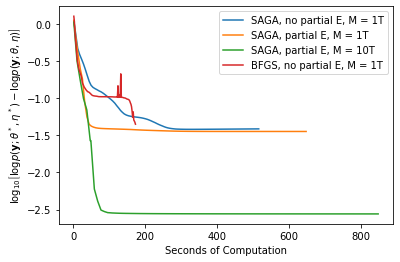

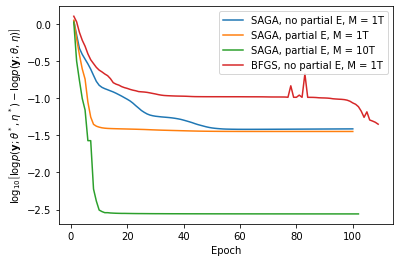

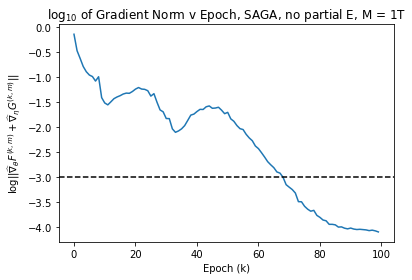

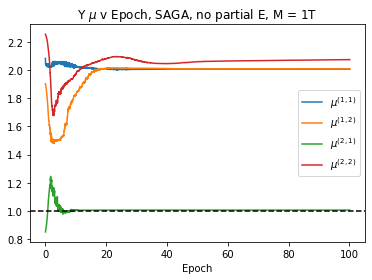

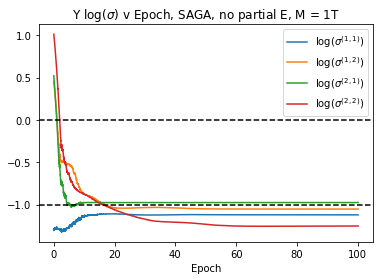

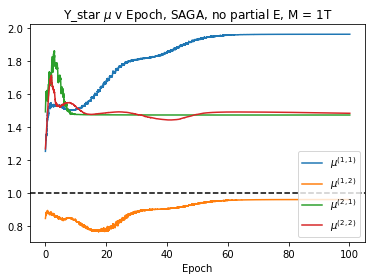

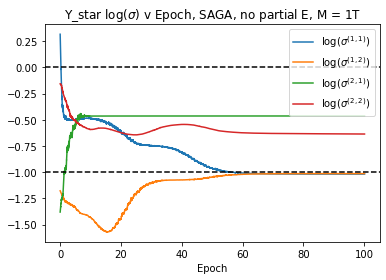

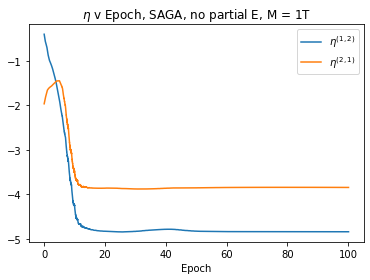

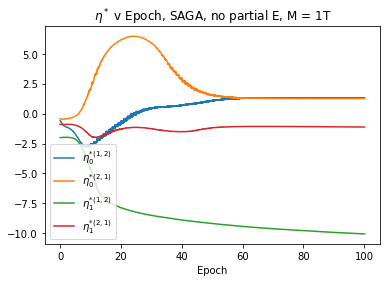

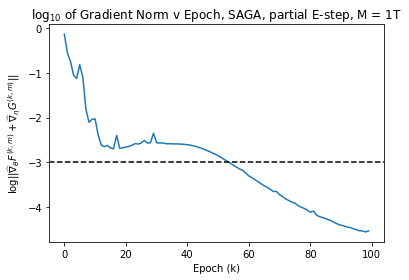

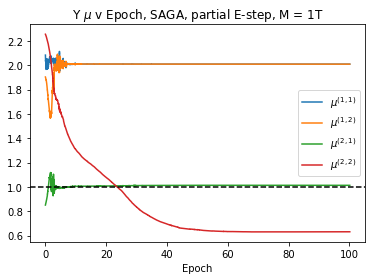

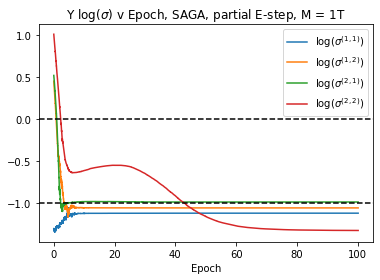

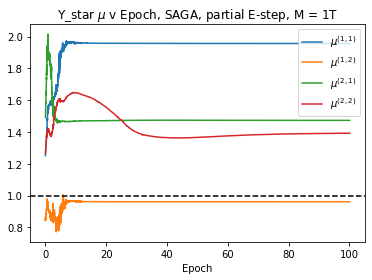

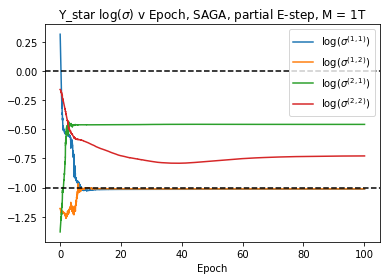

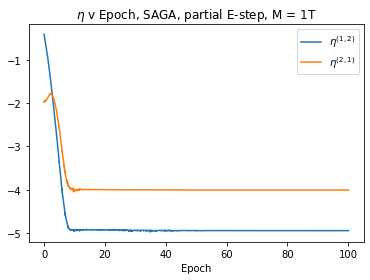

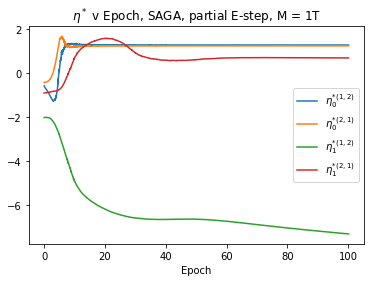

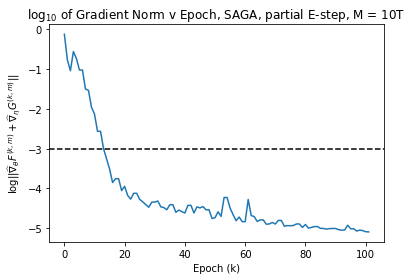

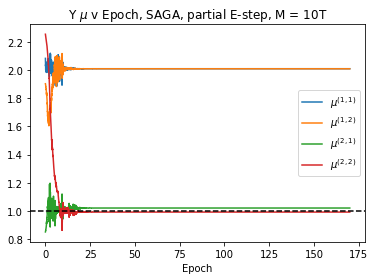

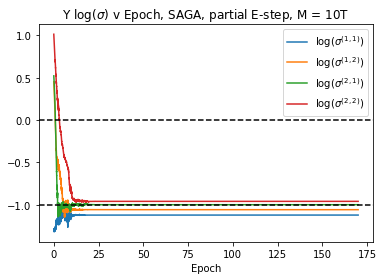

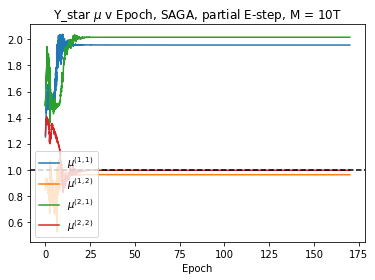

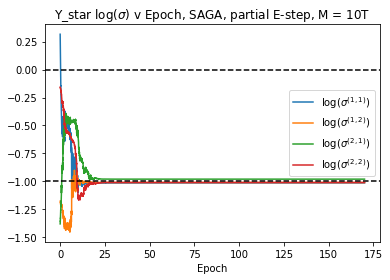

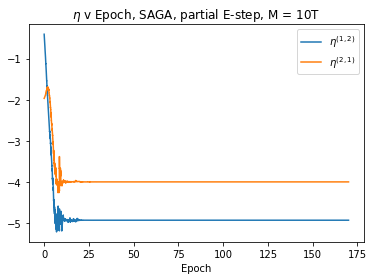

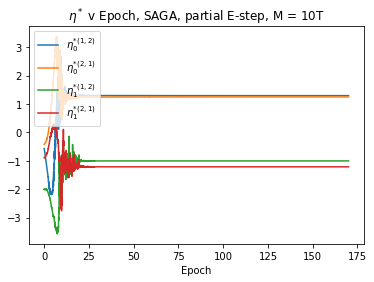

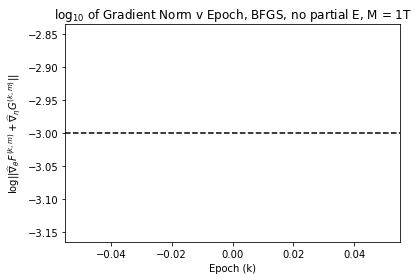

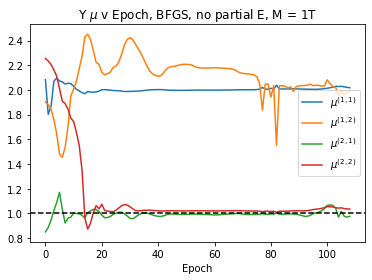

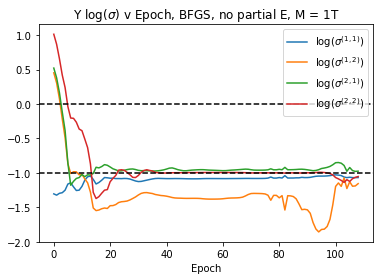

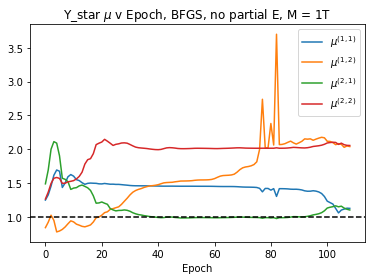

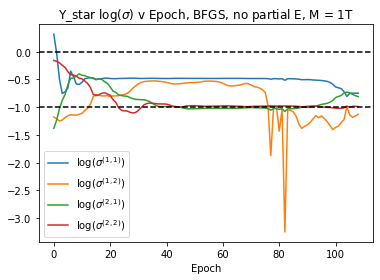

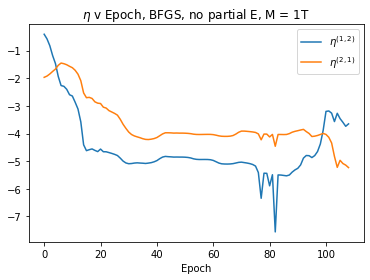

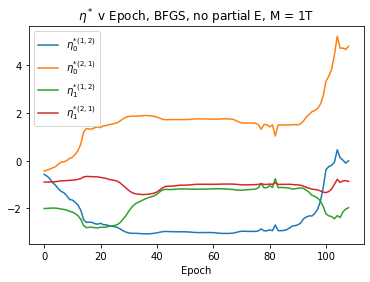

In [43]:
plot_ll(optims,x_time=True)
plot_ll(optims,x_time=False)

for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],optim_ll,method,PE,M,["Y","Y_star"])

# Check gradient accuracy

In [ ]:
key = ('SAGA', 0.5)
k0 = 0
k1 = 0
param = "mu"

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].theta[1][k0]["Y"][param][k1] += delta

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].theta[1][k0]["Y"][param][k1] -= delta

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_theta[1][k0]["Y"][param][k1]

print(fd_grad)
print(grad)

In [ ]:
key = ('GD', 0)

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_eta[0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)
k0 = 1

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].eta[1][k0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].eta[1][k0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_eta[1][k0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('SAGA', 0.5)
k0 = 0
k1 = 0
param = "log_sig"
t = 0

k = k0*optims[key].K[1] + k1

optims[key].E_step()

delta = 1e-10

ll_0 = optims[key].get_log_f(t)[0][k]
#print(ll_0)

optims[key].theta[1][k0]["Y"][param][k1] += delta

ll_1 = optims[key].get_log_f(t)[0][k]
#print(ll_1)

optims[key].theta[1][k0]["Y"][param][k1] -= delta

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].get_log_f(t)[1][1][k0]["Y"][param][k1]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)
k0 = 1

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

G_0 = optims[key].get_log_Gamma()[0]
print(G_0)

optims[key].eta[1][k0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = optims[key].get_log_Gamma()[0]
print(G_1)

optims[key].eta[1][k0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_log_Gamma()[2]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

G_0 = optims[key].get_log_Gamma()[0]
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = optims[key].get_log_Gamma()[0]
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_log_Gamma()[2]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

t = 8

optims[key].E_step()

delta = 1e-8

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)[0][0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

k0 = 0

i = 1

t = 15

optims[key].E_step()

delta = 1e-4

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta0[1][k0][i] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta0[1][k0][i] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)[1][1][k0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

t = 1

optims[key].E_step()

delta = 1e-8

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)

print(fd_grad)
print(grad)

#optims["control"].theta